# Twitter US Airline Sentiment

***

# Overview

### Dataset description

The Twitter US Airline Sentiment dataset ([Kaggle version](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)) consists of 14640 tweets, collected during February 2015, regarding six major US airlines.  
Tweets are classified as carrying negative, neutral or positive sentiment; in the case of negative tweets, the reason for the sentiment is also specified.  

### Exercise requirements

The [exercise](https://fellowship.ai/challenge) requires us to perform **sentiment analysis** on the Twitter US Airline Sentiment dataset using a [ULMFiT model](https://arxiv.org/pdf/1801.06146.pdf).  
No particular requirements on accuracy or other metrics were specified: this is as expected since the dataset does not contain a validation set. 

### Approach

We will create and train an ULMFiT model using the [fastai](https://www.fast.ai/) library based on [PyTorch](https://pytorch.org/). As we will see more in detail later, the idea behind ULMFiT is to first create an [AWD-LSTM](https://arxiv.org/abs/1708.02182) **Language Model** (LM) for tweets, i.e. a recurrent neural network that can predict the next word of a tweet given all previous words, using **transfer learning** from a Language Model trained on the [Wikitext-103 dataset](https://arxiv.org/abs/1609.07843); we then construct a tweet sentiment **classifier** using the word embedding of our language model. Performance of the model will be evaluated on a validation set that we create by taking into account the imbalanced nature of the dataset.


### Previous results

We are not aware of state of the art results for this particular dataset: this is most likely due to the fact that, as we mentioned earlier, there is no validation set. 
ULMFiT sentiment analyses for this problem that can be found in the literature or the web generally use a random subset of the training instances as validation set and as such are difficult to compare with. It is important to stress that such analyses are also often incomplete, since although they may reach a high accuracy (85% or more) it is not clear if this is due to the imbalanced nature of the dataset (e.g. often there is no discussion about the confusion matrix).

### Technical specifications

This notebook has been created as a Kaggle kernel on the Kaggle platform, which provides free GPU access.  
The Twitter US Airline Sentiment dataset can be downloaded from [https://www.kaggle.com/crowdflower/twitter-airline-sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

***

# Data analysis

### Files exploration 

Let us start by importing common useful libraries:

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from fastai import *
from fastai.text import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Data are given in csv and database.sqlite format:

In [2]:
path = Path("../input")
path.ls()

[PosixPath('../input/Tweets.csv'), PosixPath('../input/database.sqlite')]

From the csv file we can easily construct a Pandas Dataframe containing the data:

In [3]:
pd.read_csv(path/'Tweets.csv').head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We have various columns in our data, but not all of them are meaningful for our task. This is because a sentiment analysis model should predict a text sentiment (in this case negative, neutral or positive) only based on the content of the text (in this case a tweet): we should therefore only focus on the `text` and `airline_sentiment` columns. 

Nevertheless, it is also true that we don't have a pre-determined validation set and we need to create one. To this purpose it may be useful to also consider the `airline` and `negativereason` columns, since different airlines may have different strong and weak points and it could be helpful to keep those differences in both training and validation sets. 
<!--- The reason is simply that if for example we decide to split train and validation sets randomly, we may end up excluding all bad flight instances in the training set: it will therefore be harder for the model to classify tweets about bad flights as negative, since it never saw these before. --->

Let us therefore create a dataframe with all the relevant columns:

In [4]:
df = pd.read_csv(path/'Tweets.csv', usecols = ['text', 'airline_sentiment', 'airline', 'negativereason'])[['text', 'airline_sentiment', 'airline', 'negativereason']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
text                 14640 non-null object
airline_sentiment    14640 non-null object
airline              14640 non-null object
negativereason       9178 non-null object
dtypes: object(4)
memory usage: 457.6+ KB
None


,text,airline_sentiment,airline,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,Virgin America,NaN
1,@VirginAmerica plus you've added commercials t...,positive,Virgin America,NaN
2,@VirginAmerica I didn't today... Must mean I n...,neutral,Virgin America,NaN
3,@VirginAmerica it's really aggressive to blast...,negative,Virgin America,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,negative,Virgin America,Can't Tell


As we can see, we have in total 14640 tweets and for 9178 of them (the negative ones) the negative reason is also specified.

### Features analysis

Let us visualize the distribution of tweets according to the airline sentiment:

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

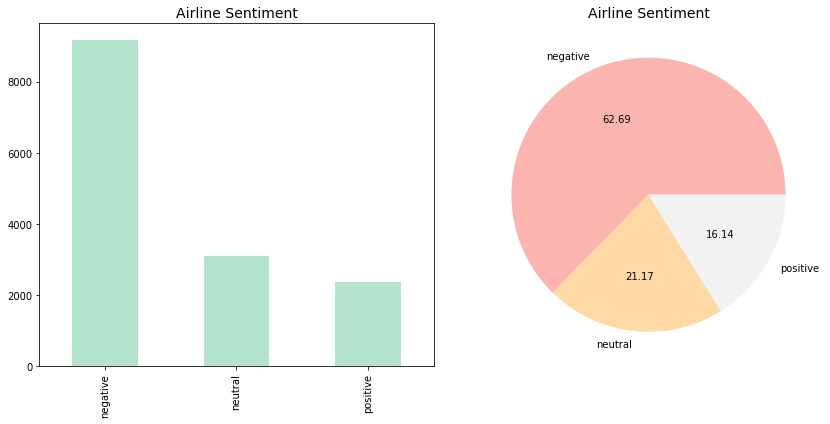

In [5]:
plt.figure(figsize = (12,6))

plt.subplot(121)
df['airline_sentiment'].value_counts().sort_index().plot(kind = 'bar', colormap = 'Pastel2')
plt.title('Airline Sentiment', size = 14)

plt.subplot(122)
df['airline_sentiment'].value_counts(normalize = True).sort_index().plot(kind = 'pie', autopct = '%.2f', colormap = 'Pastel1')
plt.title('Airline Sentiment', size = 14)
plt.ylabel(None)

plt.tight_layout()

df['airline_sentiment'].value_counts().sort_index()

We notice that our dataset is imbalanced, since we have about three times more negative tweets than neutral or positive ones (as expected, since people are more likely to tweet to complain if something is  wrong).

Let us also visualize the distribution of tweets according to the airline:

American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline, dtype: int64

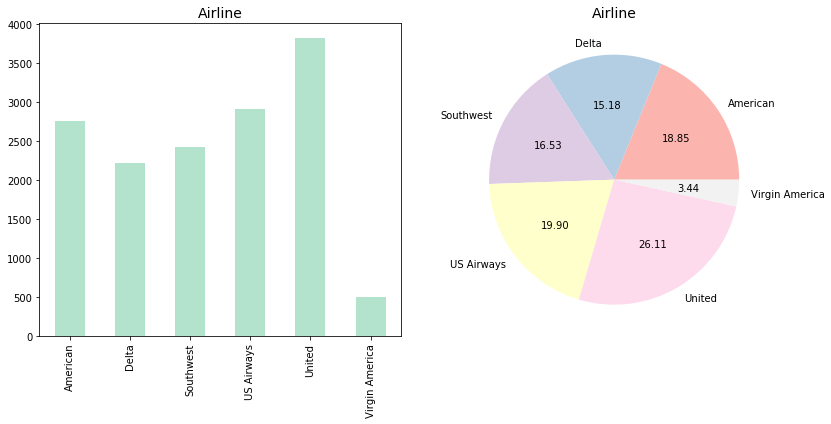

In [6]:
plt.figure(figsize = (12,6))

plt.subplot(121)
df['airline'].value_counts().sort_index().plot(kind = 'bar', colormap = 'Pastel2')
plt.title('Airline', size = 14)

plt.subplot(122)
df['airline'].value_counts(normalize = True).sort_index().plot(kind = 'pie', autopct = '%.2f', colormap = 'Pastel1')
plt.ylabel(None)
plt.title('Airline', size = 14)

plt.tight_layout()

df['airline'].value_counts().sort_index()

The number of tweets for airline company is roughly the same (although it is dominated by United), with the exception of Virgin America which only received about 3.5% of the total tweets: this is however expected since Virgin America is quite small compared to the other airline companies considered.

It may be interesting to visualize the sentiment distribution per airline: 

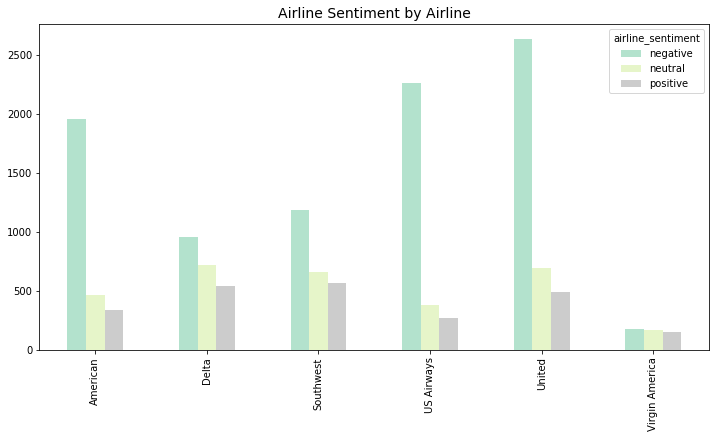

In [7]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind = 'bar', stacked = False, colormap = 'Pastel2', figsize = (12,6))
plt.title('Airline Sentiment by Airline', size = 14)
plt.xlabel(None)
plt.show()

We see that while for all companies the number of neutral and positive tweets is roughly the same, the number of negative tweets varies a lot across companies: indeed American, US Airways and United received about four/five times more negative than neutral or positive tweets, while the negative/non-negative ratio is way smaller for the remaining companies and almost one for Virgin America. In particular, among the big companies it seems that Delta provides the best service.

This may be an indicator of the airline company overall quality, but we should take into account that negative tweets may also be due to reasons out of the airline's control (such as delayed flights due to bad weather conditions). It is therefore important to visualize the distribution of reason for negative sentiment:

Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
Name: negativereason, dtype: int64

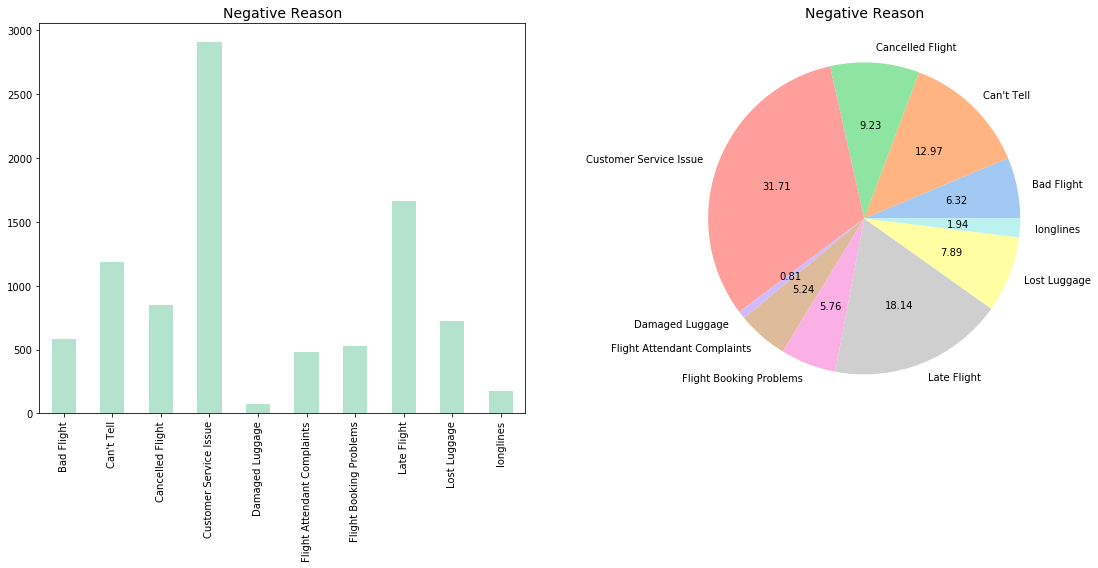

In [8]:
plt.figure(figsize = (16,8))

plt.subplot(121)
df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts().sort_index().plot(kind = 'bar', colormap = 'Pastel2')
plt.title('Negative Reason', size = 14)

plt.subplot(122)
df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts(normalize = True).sort_index().plot(kind = 'pie', autopct = '%.2f', colors = sns.color_palette("pastel", 10))
plt.ylabel(None) 
plt.title('Negative Reason', size = 14)

plt.tight_layout()

df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts().sort_index()

From the plot it is clear that the most frequent complaint reason is related to issues with customer service, which is due to the airline companies themselves. Other frequent complaints (apart from the unspecified ones, collectively collected as "can't tell") regard late/cancelled flights and lost luggage, which however may not always be attributed to the airline companies but may be due to external factors such as bad weather or bad airport organization.  
Less frequent complaint reasons are instead most likely problems related to the airline companies (flight attendants, flight booking, long lines, bad flights).

To get an estimation of the airlines quality we should therefore compare the non-external negative sentiment reasons for the various companies:

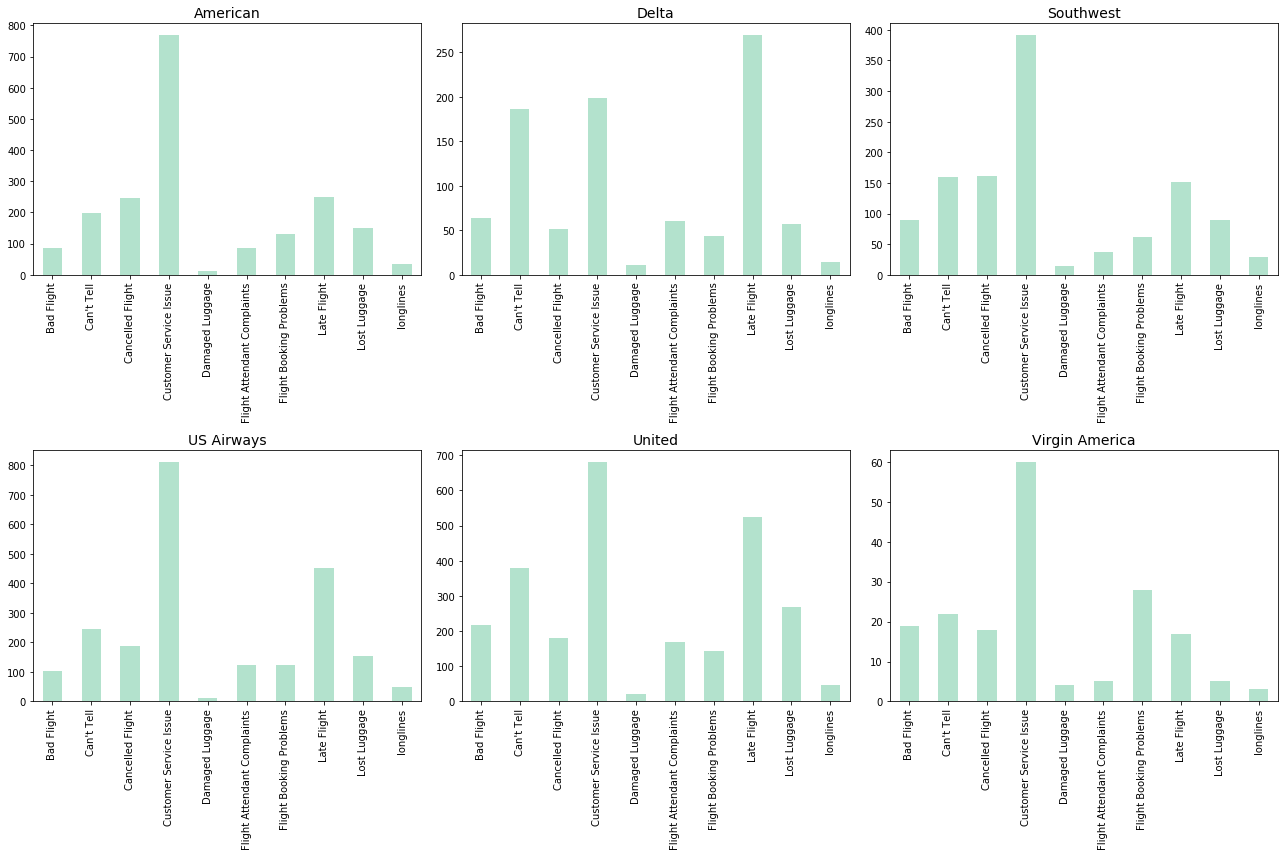

In [9]:
plt.figure(figsize = (18,12))

airlines = df['airline'].value_counts().sort_index().index.tolist()

for i in range(len(airlines)):
    plt.subplot(2,3,i+1)
    df[(df['airline_sentiment'] == 'negative') & (df['airline'] == airlines[i])]['negativereason'].value_counts().sort_index().plot(kind = 'bar', colormap = 'Pastel2')
    plt.title(airlines[i], size = 14)
    
plt.tight_layout()    
plt.show()

For all companies the dominant dissatisfaction reason is related to customer service (apart from Delta whose biggest problem is due to late flights, but this may not be entirely due to Delta). We confirm once more that among the big companies Delta seems to provide a better overall service, given that its number of customer service issues is much lower compared to the one of the other big companies.

### Text analysis

In a sentiment analysis problem the text (here tweets) is the most important feature, since the model should predict a sentiment based solely on it.  
We should therefore give a look on a few tweet examples to understand the general properties of our text and possible sources of issues during training:

In [10]:
# Examples

for i in [0, 100, 105, 177, 1552, 3365, 3386, 3555]:
    print(df['text'][i])
    print()

@VirginAmerica What @dhepburn said.

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM

@VirginAmerica - amazing customer  service, again! 💕💕 RaeAnn in SF - she's the best! #customerservice #virginamerica #flying

@VirginAmerica - too many apologies! You r the worse airlines! Don't even respond to your cudtomers

@united:  thanks for the miserable trip GNV&lt;&lt;&lt;FSD on 2.19-2.21.

@united ANOTHER F*CKING DELAY IN THE PAST 32 HOURS!?

@united I have been denied. Not sure how you charge $150 one way then $25 on way hime

@united UA5029 from RIC, UA507 from ORD, &amp; UA423 from DEN -ALL DELAYED for non-weather issues. Way to go, youre batting 1.000! But no hotels



From these example we notice a series of points:

* Most, if not all, tweets begin with referring to a particular airline company. This may cause problems during classification: for example ~ 70% of the tweets concerning United are negative and it is then possible that the model may assign a negative feeling to the word "@united". We should therefore check that this is not the case after training the model, or remove such references to the airline companies altogether;


* Sometimes the tweet is extremely short (like in the first example) and it may be hard for the model to classify tweets with such little information;


* Differently from most of the standard written text, tweets make large use of words shortenings, mentions to other tweets, emojis, hashtags. Emojis are very likely to contain some sort of sentiment and for this reason we prefer to keep them. Hashtags may also contain some sentiment information, but it can be hard to extract it since most of the times they are created by joining words (such as "#customerservice");


* Sometimes tweets contain web links: we don't expect the name of the link to contain any relevant sentiment information, so we may decide to get rid of them; 


* Characters such as "&" have been rendered as `&amp;` in the process of storing the data as a csv file, so we may want to restore them to their original form (or eliminate them since they will likely not contain any sentiment information);


* There are sometimes mispelled words (such as "cudtomers" and "hime");


* There is a large presence of flight-specific terms, such as abbreviations for airports and cities (SF, LAX, DEN) and references to flights (UA5029, UA507);


* Numbers are often used, mostly either to indicate a date/time or to indicate prices. Numbers should not contain any relevant sentiment information, although a high sum of money may indicate something overpriced and may therefore be related to a negative tweet; 


* Capitalization of whole words of sentences often indicates anger and may therefore be an indication of a negative sentiment, but it may be hard for the model to distinguish them from abbreviations of cities (SF, LAX, DEN) which are also fully capitalized.

Many of these factors may affect the final quality of our classifier: we will however first train a classifier using the standard ULMFiT preprocessing of text, and later investigate if additional or different preprocessing steps may improve the performance of the model.

To conclude, we also notice that sometimes classification of tweets is ambiguous. For example the following four tweets only differ by the web link they refer to, but their sentiment is classified differently:

In [11]:
for i in range(109, 113):
    print("{}, {}".format(df['text'][i], df['airline_sentiment'][i]))
    print()

@VirginAmerica has getaway deals through May, from $59 one-way. Lots of cool cities http://t.co/tZZJhuIbCH #CheapFlights #FareCompare, positive

@VirginAmerica has getaway deals through May, from $59 one-way. Lots of cool cities http://t.co/RPdBpX3wNd #CheapFlights #FareCompare, neutral

@VirginAmerica has getaway deals through May, from $59 one-way. Lots of cool cities http://t.co/B2Xi4YG5T8 #CheapFlights #FareCompare, positive

@VirginAmerica has getaway deals through May, from $59 one-way. Lots of cool cities http://t.co/QDlJHslOI5 #CheapFlights #FareCompare, neutral



This and similar examples will create additional confusion and will most likely affect the ability of the model to distinguish neutral from positive/negative tweets, but there is no way to fix this problem apart from revisiting by hand the classification of all tweets.

***

# Model - ULMFiT 

The exercise requires us to perform sentiment analysis on the Twitter US Airlines Sentiment dataset by training a ULMFiT (Universal Language Model Fine-Tuning) model, introduced in the [Universal Language Model Fine-Tuning for Text Classification](https://arxiv.org/pdf/1801.06146.pdf) paper. Training a ULMFiT model is a three-steps process:

1. In the first step we train a **Language Model** (LM), e.g. a model which is able to predict the next word in a sentence given all previous words. This is a complicated and computationally expensive problem since we basically need to teach the model both the grammar and the vocabulary of a language (English in our case): as such, we expect a large number of text documents will be needed for training.   
Luckily, this first step was already done for us by the authors of the ULMFiT paper: they trained a recurrent neural network (more precisely an [AWD-LSTM](https://arxiv.org/abs/1708.02182) model) on the [Wikitext-103 dataset](https://arxiv.org/abs/1609.07843), which consists of 28,595 preprocessed Wikipedia articles, over 103 million tokens and a vocabulary size of 267,735, and made availabe for download the weights of their trained model. We then just need to construct an AWD-LSTM architecture and load the pre-trained weights, much like when in computer vision we use ResNet or similar models pre-trained on the ImageNet dataset.


2. In the second step we use **transfer learning** and fine-tune the pre-trained language model to our dataset. This step is necessary because often the English used in the text we need to consider is different from Wikipedia's English, especially in our case where we are dealing with tweets which also involve emojis and hashtags. This is essentially the same step we perform in computer vision, where we use transfer learning from a ResNet or similar model pre-trained on ImageNet and fine-tune it on our new image dataset. Notice however that we are not yet using the sentiment labels of our texts, since in a language model the target is the next word of the sentence: this step can then be considered as a self-supervised problem.


3. In the third step we build a sentiment **classifier** model by adding to the language model two linear layers with ReLU and softmax activations functions. It is only during this last part that we make use of the tweets sentiment labels. 

Compared to training a classifier model from scratch, ULMFiT allows to get good results with much fewer labeled training data: it will therefore be faster to train and less computational expensive (the only hard step being the first one, which however we don't need to perform).

Let us now go more in details into the various steps.

### Step 1: download the pre-trained Language Model

In order to build a language model, we need to somehow convert text to numbers: this is because computers can perform computations on numbers, but not on text. This conversion is usually done by **tokenization** and **numericalization** of the full text corpus.

**Tokenization** is the process of creating a separate unit (*token*) for each separate part of a word. Most of the times a token consists of a single word, but cases like "it's" are usually divided into the two tokens "it" and "'s"; moreover punctuation and other symbols (like emojis) get their own token, and additional special tokens (for example "xxmaj" for capital letters or "xxunk" for unknown words) may be used. Fastai has a Tokenizer class that uses a [spacy tokenizer](https://spacy.io/usage/spacy-101#annotations-token) to perform tokenization:

In [12]:
# Original text example

print('Original text:   ', df['text'][455])
print()

# Tokenization

tokenizer = Tokenizer()
text_tokens = tokenizer.process_text(df['text'][455], tok = SpacyTokenizer('en'))    # 'en' for English language

# Tokenized text

print('Tokenized text:  ', ' '.join(text_tokens))
print()

# Tokens

print('Tokens:', text_tokens)

Original text:    @VirginAmerica now it's just t-minus 32 minutes until my Elevate a Silver upgrade window opens . #FreeNeverSucks 😃👍

Tokenized text:   @virginamerica now it 's just t - minus 32 minutes until my xxmaj elevate a xxmaj silver upgrade window opens . # freeneversucks 😃 👍

Tokens: ['@virginamerica', 'now', 'it', "'s", 'just', 't', '-', 'minus', '32', 'minutes', 'until', 'my', 'xxmaj', 'elevate', 'a', 'xxmaj', 'silver', 'upgrade', 'window', 'opens', '.', '#', 'freeneversucks', '😃', '👍']


As we can see, the fastai built-in tokenizer considers each emoji as a single token; in addition, it separates hashtags into "#" and whatever word comes after it. It also trades the appeareance of capital letters in a word for the special token "xxmaj", apart from the case where capital letters appear in the first word (since later it will add another special token "xxbos" which indicates the beginning of sentence).

**Numericalization** instead is the process of constructing a vocabulary and assign a number to each token. The fastai Vocab class will create a vocabulary out of a list of tokens we pass to it, considering only the `max_vocab` most frequent tokens which appear in the token list at least `min_freq` times (in addition to nine special tokens). It will then assign a unique number to each token in the vocabulary. The dictionary between vocabulary tokens and integers can be read from the Vocab `stoi` method:

In [13]:
vocab = Vocab.create([text_tokens], max_vocab = 1000, min_freq = 1)
vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             '@virginamerica': 9,
             'now': 10,
             'it': 11,
             "'s": 12,
             'just': 13,
             't': 14,
             '-': 15,
             'minus': 16,
             '32': 17,
             'minutes': 18,
             'until': 19,
             'my': 20,
             'elevate': 21,
             'a': 22,
             'silver': 23,
             'upgrade': 24,
             'window': 25,
             'opens': 26,
             '.': 27,
             '#': 28,
             'freeneversucks': 29,
             '😃': 30,
             '👍': 31})

We can numericalize a tokenized text with the Vocab `numericalize` method:

In [14]:
print('Tokens:', text_tokens)
print()
print("Tokens to numbers:", vocab.numericalize(text_tokens))

Tokens: ['@virginamerica', 'now', 'it', "'s", 'just', 't', '-', 'minus', '32', 'minutes', 'until', 'my', 'xxmaj', 'elevate', 'a', 'xxmaj', 'silver', 'upgrade', 'window', 'opens', '.', '#', 'freeneversucks', '😃', '👍']

Tokens to numbers: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 5, 21, 22, 5, 23, 24, 25, 26, 27, 28, 29, 30, 31]


If we now try to numericalize a tokenized text which contains tokens not present in the vocabulary, these will be replaced by the special `xxukn` token (numericalized as 0):

In [15]:
tokenized_sample_text = tokenizer.process_text("@virginamerica It's just me!", tok = SpacyTokenizer('en'))
print(vocab.numericalize(tokenized_sample_text))

[9, 5, 11, 12, 13, 0, 0]


Tokenization and numericalization are automatically performed by fastai when creating the data to be fed into the language model with `TextDataBunch`.   
All we need to specify is where the data is stored (in our case the csv file), how to split data into training and validation (here we just take a random 10% of the data as validation), which column contains the text and which column contains the labels (to be used later for classification), the maximum number of tokens in the vocabulary (60000 by default as more would lead to a model more prone to errors) and the minimum number of times a token should appear for being considered as part of the vocabulary:

In [16]:
data_lm = TextLMDataBunch.from_csv(path, 'Tweets.csv', valid_pct = 0.1, 
                                   text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)

`TextDataBunch` also splits the text corpus into mini-batches of 64 elements, where each element in a mini-batch is a text of 70 tokens: 

In [17]:
data_lm.show_batch(3)

idx,text
0,at xxmaj lax was fantastic tonight helping to find a lost item for us at the airport . xxmaj much thanks ! xxbos @jetblue of my tray table is broken what do i do ? xxbos @americanair ... xxmaj do i have to even say anything ? xxmaj over 6 hours on hold ... xxmaj no one has ever sucked as much as you . http : / / t.co
1,", & & gate crews at c19 xxmaj bos & & 6 jfk . xxmaj long day of delays made better by them ! xxbos @southwestair xxmaj make the world a better place : xxmaj visit an elderly relative . xxbos @united well . xxmaj as of yet , our checked bag has already xxunk and we have n't left the airport yet . xxbos @united xxmaj apologize to the"
2,"to the earlier flight but i 'm at the gate with a seat assignment . xxmaj super nice agent at gate xxup c4 xxup ord xxbos @usairways xxmaj official time of call 3 hours 10 minutes but must add for 7 minutes your reservation agent was extremely professional and helpful xxbos @usairways sorry , we are in xxmaj philly . xxmaj should 've told you that . xxbos @americanair really"


The language model training data x of a mini-batch is therefore a (numericalized) 64 x 70 tensor; the target data y is also a 64 x 70 tensor and contains at each step the next word for the text in x:

In [18]:
x,y = next(iter(data_lm.train_dl))
print(x.shape)
print(y.shape)

torch.Size([64, 70])
torch.Size([64, 70])


In [19]:
x

tensor([[  16,    0,    2,  ...,  197,  136,  411],
        [   5, 3597,    9,  ...,  111,  183,    9],
        [  15,    5,   41,  ...,   44,  333,  120],
        ...,
        [  19,  157,  275,  ...,   11,   38,   68],
        [  62,  104,   43,  ...,  262,   81,  114],
        [  14, 6271,    0,  ..., 2994,   29,    6]], device='cuda:0')

In [20]:
y

tensor([[   0,    2,   32,  ...,  136,  411,   35],
        [3597,    9,    5,  ...,  183,    9,    5],
        [   5,   41,  159,  ...,  333,  120,  113],
        ...,
        [ 157,  275,   55,  ...,   38,   68,  143],
        [ 104,   43,    2,  ...,   81,  114,   25],
        [6271,    0,    9,  ...,   29,    6,  110]], device='cuda:0')

For example, given the first six tokens "/ xxunk xxbos @jetblue the you" in x, the target word in y is the sixth token "above":

In [21]:
print(data_lm.vocab.textify(x[0,:]))
print()
print(data_lm.vocab.textify(y[0,:]))

/ xxunk xxbos @jetblue the you above all commercials ? xxmaj like the legroom one xxbos @americanair i am going to keep these tweets coming till xxup aa does something ... which i know is nothing .. hoping i go way ... not likely . xxbos @usairways there is nothing tonight and i am on the flight now with xxup gogo internet is there a way that someone could send

xxunk xxbos @jetblue the you above all commercials ? xxmaj like the legroom one xxbos @americanair i am going to keep these tweets coming till xxup aa does something ... which i know is nothing .. hoping i go way ... not likely . xxbos @usairways there is nothing tonight and i am on the flight now with xxup gogo internet is there a way that someone could send me


Once the language model data has been specified, we can construct an AWD-LSTM model pre-trained on Wikitext-103 by calling the fastai `language_model_learner()` function (`drop_mult` is an overall factor multiplying the dropout rates of all layers):

In [22]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')

Let us look at the architecture of the AWD-LSTM model:

<!--- We can explicitly see that the architecture is the AWD-LSTM one, with an embedding layer transforming the 6298 vocabulary items into 400 features, three LSTM recurrent layers and a final output layer: --->

In [23]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(6298, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(6298, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=6298, bias=True)
    (output_dp): RNNDropout()
  )
)

In [24]:
print("Number of words in the vocabulary:", len(data_lm.train_ds.vocab.itos))

Number of words in the vocabulary: 6298


The first layer is an embedding layer which represents each word in the vocabulary (6298 in this case) as a 400-dimensional vector. This is followed by three LSTM layers of size 400 x 1150, 1150 x 1150, 1150 x 400 respectively. Finally we have a decoding layer which outputs one of the words in the vocabulary given a 400-dimensional vector. Dropout is applied whenever possible, but in a careful way to retain long term dependencies in a sentence.

Since our model is already pre-trained, we can try to see how good it is in predicting new words. For example, we can try to predict the next two words for the simple sentence "I would like":

In [25]:
text = "I would like"
for i in range(2):
    text = learn_lm.predict(text)
print(text)

I would like to use 


The prediction is quite reasonable in this simple case: the pre-trained language model seems to already work well at least for easy sentences.

### Step 2: fine-tune the Language Model 

Now that we have our language model pre-trained on Wikitext-103, we can use **transfer learning** and fine-tune it to the dataset of interest in order to make it able to understand the peculiarities of the text we need to analyse (in our case tweets). As for transfer learning in computer vision, the idea is to first replace and train only the last layer (decoder) of the neural network on the new dataset, and later unfreeze the whole architecture and train a little longer. 

As for any problem involving transfer learning, there are a couple of techniques that usually help in producing better models:

* **One-cycle policy**, i.e. for each training epoch first gradually increase the learning rate till a maximum value and later gradually decrease it (and do the opposite for momentum). This can be useful since increasing the learning rate at the beginning of the epoch may prevent us from being stuck in an unwanted local minimum or saddle point of the loss function. One-cycle learning is already implemented in fastai via the `fit_one_cycle` method.


* **Discriminative fine-tuning**, i.e. using different learning rates for different hidden layers (more precisely, smaller learning rate for the first layers and bigger learning rate for the last layers). This is helpful because, as in computer vision, different layers contain different types of information: typically the first layers contain the most general information about our data (in our case basic structures of English language: subject + verb + object, ...), which is most likely already well taken into account by the pre-training on the huge Wikitext-103 dataset and therefore will only need a small fine-tuning; on the other hand the last layers contain the least general information, such as peculiarities of tweets, and will need more training. Discriminative fine-tuning is already implemented in fastai: we just need to pass `max_lr` in `fit_one_cycle` as a `slice()` of two numbers, which will be the maximum learning rate (according to the one-cycle policy) for the first and last layer; the maximum learning rate across all layers will then be gradually increasing between these two values (setting `max_lr` to a single number will instead assign the same maximum learning rate of the one-cycle policy to all layers). A similar procedure works for momentum, if we specify `mom` as a tuple of two numbers.

Let us now perform fine-tuning of the language model on our Twitter US Airline Sentiment dataset. We first randomly split the data into a training (90%) and a validation (10%) dataframe, and create a TextDataBunch and a pre-trained language model with such data (by default all layers apart from the last one are frozen):

In [26]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits = 1, test_size = 0.1)

for train_idx, valid_idx in split.split(df['text'], df['airline_sentiment'].values):
    df_train = df.iloc[train_idx]
    df_valid = df.iloc[valid_idx]

In [27]:
data_lm = TextLMDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                                  text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)

In [28]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')

The learning rate can be determined with the `lr_find()` method, which runs the model for a subset of data at a learning rate increasing at each batch; plotting the loss as a function of the learning rate and looking for where it decreases fastest tells us which learning rate would be best:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


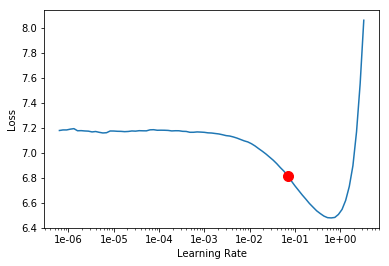

In [29]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion = True)

Once the learning rate is determined, we can train the last layer for one epoch (momentum is chosen as suggested in the ULMFiT paper):

In [30]:
learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,5.011518,4.096539,0.243279,00:07


Now we can unfreeze the whole architecture and train a little longer:

In [31]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


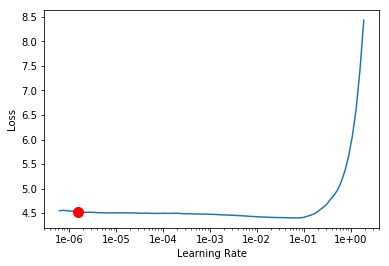

In [32]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion = True)

The ratio 2.6 between learning rates of the four different layers is chosen as suggested by the ULMFiT paper:

In [33]:
learn_lm.fit_one_cycle(10, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms = (0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,4.409779,3.970571,0.258805,00:09
1,4.233493,3.839709,0.271007,00:09
2,4.059652,3.745497,0.280332,00:09
3,3.884140,3.682714,0.286334,00:09
4,3.736500,3.647983,0.293824,00:09
5,3.614657,3.626409,0.295883,00:09
6,3.499692,3.615539,0.299082,00:09
7,3.402600,3.617137,0.298562,00:09
8,3.337576,3.618863,0.299802,00:09
9,3.304339,3.618863,0.299107,00:09


We see that we can easily reach 30% accuracy on the task of predicting the next word (or token) in a tweet. Although 30% may not seem like a big number, it is actually a very good result for a task as complex as predicting the next word, which is very hard even for humans.

It is however still possible that our 30% accuracy may be due to a particularly lucky random choice of validation set. To show that this is not the case, let us train the same model using a ten-fold cross validation:

In [34]:
from sklearn.model_selection import KFold

split = KFold(n_splits = 10, shuffle = True)

val_losses = []
accuracies = []

for train_idx, valid_idx in split.split(df['text'], df['airline_sentiment'].values):
    df_train = df.iloc[train_idx]
    df_valid = df.iloc[valid_idx]
    
    data_lm = TextLMDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                                   text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)
    
    learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')
    
    learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))  
    
    learn_lm.unfreeze()
    
    learn_lm.fit_one_cycle(10, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms=(0.8,0.7))    # it was 6 earlier
    
    val_losses.append(round(learn_lm.recorder.val_losses[-1] ,6))
    accuracies.append(round(learn_lm.recorder.metrics[-1][0].item() ,6))

epoch,train_loss,valid_loss,accuracy,time
0,5.020207,4.158767,0.240551,00:07


epoch,train_loss,valid_loss,accuracy,time
0,4.409891,4.032531,0.254191,00:09
1,4.228420,3.883692,0.270858,00:09
2,4.044726,3.784932,0.277976,00:09
3,3.876483,3.719932,0.285317,00:09
4,3.737428,3.689532,0.287054,00:09
5,3.600636,3.667767,0.291642,00:09
6,3.491460,3.658186,0.293725,00:09
7,3.399613,3.655804,0.296007,00:09
8,3.336157,3.657502,0.296528,00:09


The mean accuracy is very near 30% with a small standard deviation and also the validation loss is stable across the validation folds. We can therefore conclude that our language model can get an accuracy of around 30% in a quite robust way.

In [35]:
print('Accuracies:', accuracies)
print('Accuracies mean:', np.array(accuracies).mean().round(6))
print('Accuracies standard deviation:', np.array(accuracies).std().round(6))
print()
print('Validation losses:', val_losses)
print('Validation losses mean:', np.array(val_losses).mean().round(6))
print('Validation losses standard deviation:', np.array(val_losses).std().round(6))

Accuracies: [0.297712, 0.299219, 0.30119, 0.298735, 0.296181, 0.30067, 0.295396, 0.301959, 0.293862, 0.301395]
Accuracies mean: 0.298632
Accuracies standard deviation: 0.002643

Validation losses: [3.65917, 3.625146, 3.624174, 3.648218, 3.658716, 3.622477, 3.670131, 3.617164, 3.68, 3.616764]
Validation losses mean: 3.642196
Validation losses standard deviation: 0.022549


From the practical point of view however we would like to train the language model with as much data as possible. Let us therefore train our final language model on all but a few tweets:

In [36]:
data_lm = TextLMDataBunch.from_csv(path, 'Tweets.csv', valid_pct = 2/14640, 
                                   text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)

The validation accuracy in this case is quite smaller, but this is most likely due to having particularly hard tweets in our small validation set:

In [37]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')

learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms = (0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,4.973508,4.154365,0.236830,00:08


epoch,train_loss,valid_loss,accuracy,time
0,4.386275,4.015710,0.245536,00:10
1,4.218118,3.917020,0.272545,00:10
2,4.035898,3.789391,0.291518,00:10
3,3.870740,3.753504,0.302679,00:10
4,3.720837,3.776610,0.260714,00:10
5,3.585208,3.751255,0.257812,00:10
6,3.482366,3.756847,0.270089,00:10
7,3.394685,3.753621,0.261830,00:10
8,3.323092,3.734677,0.251339,00:10
9,3.284602,3.741892,0.250893,00:10


Indeed many words in our three validation tweets are unknown and we also have the presence of a website:

In [38]:
for i in range(len(data_lm.valid_ds)):
    print(data_lm.valid_ds.x[i])
    print()

xxbos @americanair your a xxup xxunk , no precipitation all day , 47 degrees , do n't xxunk , you look like a xxunk xxrep 7 . that s the problem , admit you suck

xxbos @united boarding time shows 35 min and your gate agent started at 45 . showed up at xxunk and they had to check bag . http : / / t.co / xxunk

xxbos @americanair xxmaj thanks ! xxmaj xxunk , disconnected ! xxmaj let 's try this again ! !



This however will not affect the quality of our language model fine-tuned on the tweets dataset. Indeed we can use this model to predict the next three words of a tweet starting as "@united how do":

In [39]:
text = "@united how do"
for i in range(3):
    text = learn_lm.predict(text)
print(text)

@united how do i try your


The predictions may not be our first guess, but they are quite reasonable: for example we get a standard subject + verb + object structure.

We can now save both the language model and its encoder, which will be used for constructing the classifier model:

In [40]:
learn_lm.save('/kaggle/working/fine_tuned_lm')
learn_lm.save_encoder('/kaggle/working/fine_tuned_enc')

### Step 3: create a Classifier Model 

Now that we have a good language model fine-tuned on our Twitter US Airlines Sentiment dataset, we should construct a classifier model which can predict the sentiment of a tweet based solely on its text content.

Before starting to construct the model we should first address the problem of reasonably splitting our data into a training and validation set, since there is no given validation set. We already saw that the sentiment distribution is imbalanced, since there are three times more negative than neutral/positive tweets: we should therefore at least ensure all three sentiments are represented both in the training and the validation sets (otherwise we may have only negative tweets in the training set if we were to use a naive random split, which would make almost impossible to have good performance on other sentiments).   
We believe keeping the same number of negative, neutral and positive tweets in the training set will be the best course of action, since in this way the model will be more likely to be exposed to around the same number of words that are inherently negative, positive or without any particular sentiment. We therefore choose a train set of 2100 x 3 = 6300 tweets equally distributed among the three sentiments (2100 leaves 263 positive tweets, i.e. ~ 10% of all positive tweets, for validation).  
We also choose to stratify the 2100 training negative tweets according to the negative reason feature, in such a way to let the model be exposed to as many different words related to negative sentiments as possible. We cannot do the same for neutral and positive tweets since we do not have an analogue information, so we decide instead to stratify them according to the airline companies: this is because different companies may be better in some specific sector, but it also possible that stratifying in this way may not be that important.

For what the validation set is concerned, we decided to construct two of them. The first one, which we will refer to as test set, simply consists of all the remaining 14640 - 6300 = 8340 tweets which are not in the training set and will be used to evaluate the final performance of the classifier. The second one, which we call validation set, instead consists of 263 x 3 (i.e. 263 per sentiment) = 789 tweets not in the training set, but still stratified as we did for the training instances. This will be used as validation set to be fed to the `TextClasDataBunch` object and to evaluate the classifier model during training.  
We do so because accuracy (which is used as evaluation metric during training) would be completely meaningless if we were to use the whole 8340 remaining tweets, since around 85% of them will be negative and simply predicting all tweets to be negative would give a high accuracy: on the other hand, keeping the same number of negative, neutral and positive tweets in the validation set used during training will give more meaning to the accuracy.

Let us therefore construct training, validation and test dataframes as just described:

In [41]:
# Separate indices of negative, neutral, positive tweets

idx_neg = df[df['airline_sentiment'].values == 'negative'].index
idx_neu = df[df['airline_sentiment'].values == 'neutral'].index
idx_pos = df[df['airline_sentiment'].values == 'positive'].index

# Stratify train and validation set according to 'negativereason' or 'airline' (for neutral and positive tweets)

from sklearn.model_selection import StratifiedShuffleSplit

split_neg = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
split_neu = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
split_pos = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)

for train_idx, valid_idx in split_neg.split(df['negativereason'].loc[idx_neg], df['negativereason'].loc[idx_neg]):
    train_idx_neg = (np.array(idx_neg)[train_idx]).tolist()
    valid_idx_neg = (np.array(idx_neg)[valid_idx]).tolist()
    test_idx_neg = [idx for idx in idx_neg if idx not in train_idx_neg]    # test set: all tweets not in training set
    
for train_idx, valid_idx in split_neu.split(df['airline'].loc[idx_neu], df['airline'].loc[idx_neu]):
    train_idx_neu = (np.array(idx_neu)[train_idx]).tolist()
    valid_idx_neu = (np.array(idx_neu)[valid_idx]).tolist()
    test_idx_neu = [idx for idx in idx_neu if idx not in train_idx_neu]
    
for train_idx, valid_idx in split_pos.split(df['airline'].loc[idx_pos], df['airline'].loc[idx_pos]):
    train_idx_pos = (np.array(idx_pos)[train_idx]).tolist()
    valid_idx_pos = (np.array(idx_pos)[valid_idx]).tolist()
    test_idx_pos = [idx for idx in idx_pos if idx not in train_idx_pos]
    
df_train = df.loc[train_idx_neg + train_idx_neu + train_idx_pos].sample(frac = 1)
df_valid = df.loc[valid_idx_neg + valid_idx_neu + valid_idx_pos].sample(frac = 1)
df_test = df.loc[test_idx_neg + test_idx_neu + test_idx_pos].sample(frac = 1)

print("Number of training instances:  ", len(df_train))
print("Number of validation instances: ", len(df_valid))
print("Number of test instances: ", len(df_test))

Number of training instances:   6300
Number of validation instances:  789
Number of test instances:  8340


The tweets are now divided as follows:

In [42]:
print('Full dataset:')
print()
print(df['airline_sentiment'].value_counts())
print()

print('Training dataset:')
print()
print(df_train['airline_sentiment'].value_counts())
print()

print('Validation dataset:')
print()
print(df_valid['airline_sentiment'].value_counts())
print()

print('Test dataset:')
print()
print(df_test['airline_sentiment'].value_counts())

Full dataset:

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Training dataset:

positive    2100
negative    2100
neutral     2100
Name: airline_sentiment, dtype: int64

Validation dataset:

negative    263
neutral     263
positive    263
Name: airline_sentiment, dtype: int64

Test dataset:

negative    7078
neutral      999
positive     263
Name: airline_sentiment, dtype: int64


Positive and neutral tweets have been stratified based on airline companies as we requested:

In [43]:
# Positive tweets

print('Full dataset:')
print()
print(df[df['airline_sentiment'] == 'positive']['airline'].value_counts(normalize = True))
print()

print('Training dataset:')
print()
print(df_train[df_train['airline_sentiment'] == 'positive']['airline'].value_counts(normalize = True))
print()

print('Validation dataset:')
print()
print(df_valid[df_valid['airline_sentiment'] == 'positive']['airline'].value_counts(normalize = True))
print()

print('Test dataset:')
print()
print(df_test[df_test['airline_sentiment'] == 'positive']['airline'].value_counts(normalize = True))

Full dataset:

Southwest         0.241219
Delta             0.230216
United            0.208210
American          0.142192
US Airways        0.113838
Virgin America    0.064325
Name: airline, dtype: float64

Training dataset:

Southwest         0.241429
Delta             0.230000
United            0.208095
American          0.142381
US Airways        0.113810
Virgin America    0.064286
Name: airline, dtype: float64

Validation dataset:

Southwest         0.239544
Delta             0.231939
United            0.209125
American          0.140684
US Airways        0.114068
Virgin America    0.064639
Name: airline, dtype: float64

Test dataset:

Southwest         0.239544
Delta             0.231939
United            0.209125
American          0.140684
US Airways        0.114068
Virgin America    0.064639
Name: airline, dtype: float64


In [44]:
# Neutral tweets

print('Full dataset:')
print()
print(df[df['airline_sentiment'] == 'neutral']['airline'].value_counts(normalize = True))
print()

print('Training dataset:')
print()
print(df_train[df_train['airline_sentiment'] == 'neutral']['airline'].value_counts(normalize = True))
print()

print('Validation dataset:')
print()
print(df_valid[df_valid['airline_sentiment'] == 'neutral']['airline'].value_counts(normalize = True))
print()

print('Test dataset:')
print()
print(df_test[df_test['airline_sentiment'] == 'neutral']['airline'].value_counts(normalize = True))

Full dataset:

Delta             0.233301
United            0.224911
Southwest         0.214263
American          0.149403
US Airways        0.122943
Virgin America    0.055179
Name: airline, dtype: float64

Training dataset:

Delta             0.233333
United            0.224762
Southwest         0.214286
American          0.149524
US Airways        0.122857
Virgin America    0.055238
Name: airline, dtype: float64

Validation dataset:

Delta             0.231939
United            0.224335
Southwest         0.212928
American          0.148289
US Airways        0.125475
Virgin America    0.057034
Name: airline, dtype: float64

Test dataset:

Delta             0.233233
United            0.225225
Southwest         0.214214
American          0.149149
US Airways        0.123123
Virgin America    0.055055
Name: airline, dtype: float64


Negative tweets have also been stratified according to the negative reason as we requested:

In [45]:
# Negative tweets

print('Full dataset:')
print()
print(df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts(normalize = True))
print()

print('Training dataset:')
print()
print(df_train[df_train['airline_sentiment'] == 'negative']['negativereason'].value_counts(normalize = True))
print()

print('Validation dataset:')
print()
print(df_valid[df_valid['airline_sentiment'] == 'negative']['negativereason'].value_counts(normalize = True))
print()

print('Test dataset:')
print()
print(df_test[df_test['airline_sentiment'] == 'negative']['negativereason'].value_counts(normalize = True))

Full dataset:

Customer Service Issue         0.317063
Late Flight                    0.181412
Can't Tell                     0.129658
Cancelled Flight               0.092286
Lost Luggage                   0.078884
Bad Flight                     0.063195
Flight Booking Problems        0.057638
Flight Attendant Complaints    0.052408
longlines                      0.019394
Damaged Luggage                0.008063
Name: negativereason, dtype: float64

Training dataset:

Customer Service Issue         0.317143
Late Flight                    0.181429
Can't Tell                     0.129524
Cancelled Flight               0.092381
Lost Luggage                   0.078571
Bad Flight                     0.063333
Flight Booking Problems        0.057619
Flight Attendant Complaints    0.052381
longlines                      0.019524
Damaged Luggage                0.008095
Name: negativereason, dtype: float64

Validation dataset:

Customer Service Issue         0.315589
Late Flight                  

At this point we can define the TextDataBunch object for the classifier, with our stratified training and validation dataframes. We should also remember to import the vocabulary from the previously trained language model, which can be done by specifying the `vocab` option:

In [46]:
data_clas = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
            text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)

Here are a few examples of preprocessed (tokenized) labeled tweets:

In [47]:
data_clas.show_batch(10)

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
xxbos @usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # ourprincess # freyasfund # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / xxunk,neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative


The ULMFiT classifier model is simply a slightly modified AWD-LSTM, with the same encoder we used for the fine-tuned language model but different output layers. The `text_classifier_learner` function can be used to create such classifier, to which we should feed the language model encoder weights computed earlier:

In [48]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')

learn_clas.load_encoder('/kaggle/working/fine_tuned_enc')

Looking at its structure, we can indeed see that the only difference from the previous AWD-LSTM for language model is in the last layers. Instead of the decoder mapping a 400-dimensional vector to a word in our vocabulary, we now concatenate the LSTM output at the last time step with both the max-pooled and the mean-pooled representation of the hidden states at previous time steps, thus producing a 1200-dimensional vector representation of our tweet; we then have two dense layers with 50 and 3 units respectively, which will give the three possible outputs negative, neutral, positive:

In [49]:
learn_clas.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(6699, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(6699, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

Random initialization of the last layers weights results in random predictions for the untrained model, as we can see from the confusion matrix:

array([[0.828897, 0.      , 0.171103],
       [0.904943, 0.      , 0.095057],
       [0.840304, 0.      , 0.159696]])

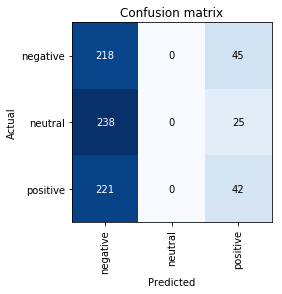

In [50]:
# Confusion matrix

learn_clas.interpret().plot_confusion_matrix()

# Normalized confusion matrix

(learn_clas.interpret().confusion_matrix())/(np.sum(learn_clas.interpret().confusion_matrix(), axis = 1).reshape(-1,1))

We should therefore train the classifier on our data. To this purpose, in addition to one-cycle policy and discriminative learning rates, the authors of the ULMFiT paper also recommend using **gradual unfreezing**: 
rather than unfreeze and train all layers at once, unfreezing and training layers one by one (starting from the output one) seems to help preventing the model forget information captured by the language model, thus resulting in a better classifier.   
Keeping all but the last n layers frozen can be done in fastai via the `freexe_to(-n)` method.

Let us start by unfreezing and training only the last layer:

In [51]:
learn_clas.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03


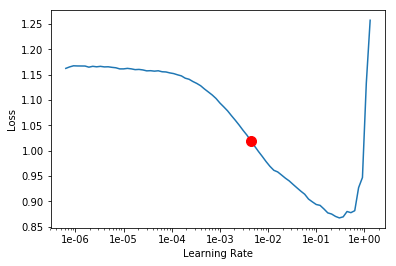

In [52]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion = True)

In [53]:
learn_clas.fit_one_cycle(1, 3e-2, wd = 1e-5, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.730959,0.721738,0.747782,00:02


The confusion matrix gets a lot better even after just a single epoch:

array([[0.882129, 0.04943 , 0.068441],
       [0.247148, 0.574144, 0.178707],
       [0.144487, 0.068441, 0.787072]])

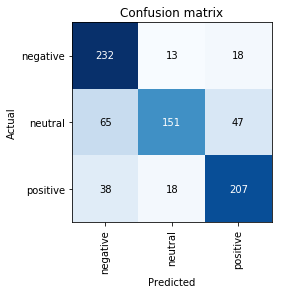

In [54]:
learn_clas.interpret().plot_confusion_matrix()
(learn_clas.interpret().confusion_matrix())/(np.sum(learn_clas.interpret().confusion_matrix(), axis = 1).reshape(-1,1))

Next we unfreeze and train the last two layers for one epoch, using discriminative learning rates:

In [55]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


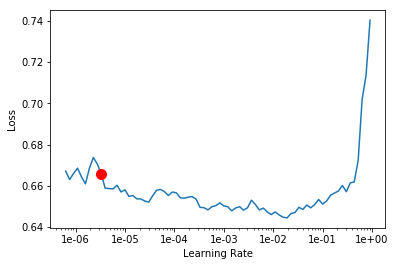

In [56]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion = True)

In [57]:
learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.642455,0.605003,0.774398,00:02


array([[0.844106, 0.079848, 0.076046],
       [0.193916, 0.657795, 0.148289],
       [0.079848, 0.098859, 0.821293]])

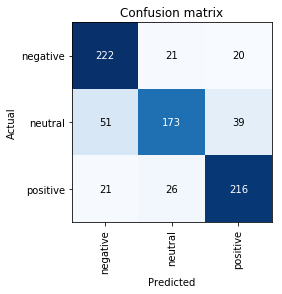

In [58]:
learn_clas.interpret().plot_confusion_matrix()
(learn_clas.interpret().confusion_matrix())/(np.sum(learn_clas.interpret().confusion_matrix(), axis = 1).reshape(-1,1))

After this we unfreeze and train for one epoch the last three layers:

In [59]:
learn_clas.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


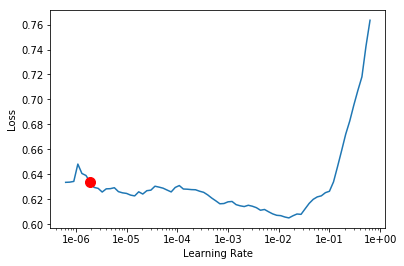

In [60]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion = True)

In [61]:
learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.632679,0.577680,0.774398,00:03


array([[0.8327  , 0.087452, 0.079848],
       [0.171103, 0.653992, 0.174905],
       [0.08365 , 0.079848, 0.836502]])

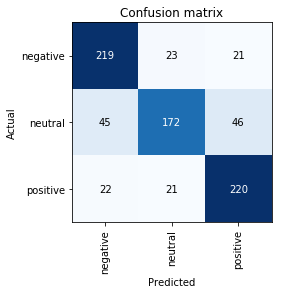

In [62]:
learn_clas.interpret().plot_confusion_matrix()
(learn_clas.interpret().confusion_matrix())/(np.sum(learn_clas.interpret().confusion_matrix(), axis = 1).reshape(-1,1))

Finally we unfreeze all layers and train the model until convergence:

In [63]:
learn_clas.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


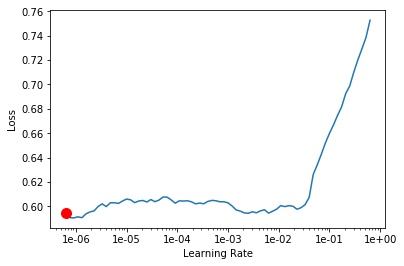

In [64]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion = True)

In [65]:
learn_clas.fit_one_cycle(8, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.609534,0.570328,0.779468,00:04
1,0.602831,0.562245,0.774398,00:04
2,0.588010,0.552519,0.785805,00:04
3,0.568145,0.546004,0.785805,00:04
4,0.547255,0.546010,0.788340,00:04
5,0.525228,0.546945,0.782003,00:04
6,0.502590,0.548775,0.778200,00:04
7,0.490706,0.546030,0.785805,00:04


array([[0.81749 , 0.102662, 0.079848],
       [0.159696, 0.695817, 0.144487],
       [0.072243, 0.08365 , 0.844106]])

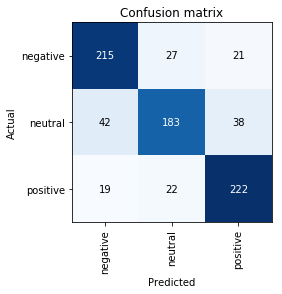

In [66]:
learn_clas.interpret().plot_confusion_matrix()
(learn_clas.interpret().confusion_matrix())/(np.sum(learn_clas.interpret().confusion_matrix(), axis = 1).reshape(-1,1))

We obtain an accuracy of around 78.5% on our validation set (i.e. the one with 263 instances for each sentiment). This is already much better than a random classifier or a naive classifier which always predicts the same sentiment; nevertheless the confusion matrix tells us that the model does not perform equally well on all classes, but seems to have some problem in distinguishing neutral from negative/positive tweets.

The same property persists when we evaluate the final model on our test set (i.e. the one with the 8340 tweets not used for training):

In [67]:
learn_clas.save('/kaggle/working/fine_tuned_clas')

array([[0.801356, 0.139729, 0.058915],
       [0.159159, 0.710711, 0.13013 ],
       [0.072243, 0.079848, 0.847909]])

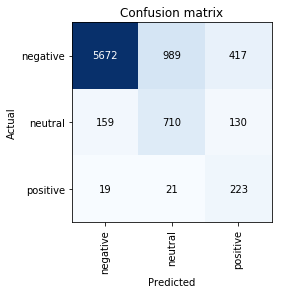

In [68]:
data_clas_test = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_test, 
                text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)

learn_clas_test = text_classifier_learner(data_clas_test, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')

learn_clas_test.load('/kaggle/working/fine_tuned_clas')

interp_test = learn_clas_test.interpret()

interp_test.plot_confusion_matrix()
(interp_test.confusion_matrix())/(np.sum(interp_test.confusion_matrix(), axis = 1).reshape(-1,1))

Considering the whole test set, we see that the model correctly classifies negative tweets 80% of the times, neutral tweets 71% of the times and positive tweets 85% of the times: it seems therefore that the model finds it a bit easier to identify positive tweets rather than negative, but has a harder time distinguishing neutral tweets from the rest (especially from negative tweets). This may have been expected, since also for humans it may be harder to tell if a text has neutral sentiment rather than positive or negative, not to mention that we saw examples in the data of very short tweets or tweets classified inconsistently.

The overall accuracy for the full test set is a bit higher than on the smaller validation set, but this is most likely due to the larger amount of negative tweets. Notice also that a naive classifier which predicts all tweets to be negative would reach an accuracy of ~84.87%, therefore accuracy is not really a reliable evaluation metric and we should rely on the confusion matrix:

In [69]:
print("Accuracy: {}%".format(round(np.trace(interp_test.confusion_matrix())/np.sum(interp_test.confusion_matrix()), 6)))
print()
print("Accuracy (predict all negative): {}%".format(round(len(test_idx_neg)/len(test_idx_neg + test_idx_neu + test_idx_pos), 6)))

Accuracy: 0.791966%

Accuracy (predict all negative): 0.848681%


*** 

# Interpretation

To understand if our model can be improved, we should look at a few examples of misclassified tweets to see which words matter most in making the prediction. We can use fastai's `show_intrinsic_attention` method for this, which highlights the most important words in the decision process:

**True sentiment neutral, predicted sentiment negative**

Some of these misclassified cases are easy to understand, since the model learned that words like "rebook", "cancelled", "lost", "confused", "not" in general carry a negative sentiment. In some other cases instead it is unclear why the sentiment is negative, nor it is clear why words like "computer" or "4322" are so important for the model. We also notice that the names of the airline companies are often relevant for determining the sentiment, even if they shouldn't: it may therefore be more appropriate to remove them during preprocessing.

In [70]:
# Add a 'predicted_sentiment' column to our dataframe

dic = {0:'negative', 1:'neutral', 2:'positive'}

predictions = torch.argmax(learn_clas_test.get_preds(ordered = True)[0], dim = 1)
predictions = [dic[predictions[i].tolist()]  for i in range(len(predictions))]

df_res = df_test.copy()
df_res['predicted_sentiment'] = predictions

# Create a fastai interpretation object

text_interp_test = TextClassificationInterpretation.from_learner(learn_clas_test)

# True sentiment neutral, predicted sentiment negative 

for i in df_res.loc[(df_res['airline_sentiment'] == 'neutral') & (df_res['predicted_sentiment'] == 'negative')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@USAirways, if I rebook on another airline after my flight was Cancelled Flightled, do you reimburse? I need to get home today, not Tuesday.', 'neutral', 'negative')


('@USAirways @AmericanAir explain how come I can get a free upgrade on US as an exe plat but not exit row seating w/out paying. confused', 'neutral', 'negative')


('@united even with the multiplier the ticket price will still never equal the amount of miles you travel, even for transatlantic flights!', 'neutral', 'negative')


('@SouthwestAir how can customers get in touch with you internationally from Mexico for lost baggage', 'neutral', 'negative')


('@USAirways I am good. I just did not understand the terminology.  but the merger brings new verbiage', 'neutral', 'negative')


('@SouthwestAir I cannot DM you as you do not follow me.', 'neutral', 'negative')


("@USAirways That's not the question. Question is: how do I get past the computer fastest if we both know that the computer can't help me?", 'neutral', 'negative')


("@united Follow me back, please, and I'll happily DM you the link because I'd rather not share my travel plans publicly.", 'neutral', 'negative')


('@USAirways yes - tells me the only way to mod plans is to call the 4322 number.', 'neutral', 'negative')


('@united the aircraft closest to gate was for the other flight and the one closest to our gate was going to Chicago.', 'neutral', 'negative')


**True sentiment negative, predicted sentiment neutral**

In most of these cases it is hard even for humans to interpret the tweets as having a negative rather than neutral sentiment, so we do not think there is much we can do. We however notice an unusual importance given to web links and symbols like "-", which we may then want to remove.

In [71]:
# True sentiment negative, predicted sentiment neutral 

for i in df_res.loc[(df_res['airline_sentiment'] == 'negative') & (df_res['predicted_sentiment'] == 'neutral')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@united I did not, my mind was on getting to the next flight.', 'negative', 'neutral')


('@JetBlue I would like to communicate directly with a "Customer Experience" executive. Does Joanna Geraghty have an email address?', 'negative', 'neutral')


('@USAirways seriously buy some WD40 for A319 operating flight 634 from GEG to Phoenix. Every seat squeaks w every shift. Still on ground!', 'negative', 'neutral')


("@AmericanAir I want the flight I have on hold. I don't want a new flight.", 'negative', 'neutral')


("@AmericanAir Is it possible to change the FF number on a passenger on a Flight Booking Problems, it won't let me change it?", 'negative', 'neutral')


("@AmericanAir any idea what's up with flight AA3181?", 'negative', 'neutral')


("@AmericanAir If it's in my backpack, why do I need to see agent?", 'negative', 'neutral')


('@jetblue fly 2301 delayed do to ice at JFK ... Can I switch to a Late Flightr flight for free', 'negative', 'neutral')


('@AmericanAir is that something the crew on the current leg can request of the gate team on the next leg?', 'negative', 'neutral')


("@AmericanAir there's a lot of talks and no doing. \nMIA-SFO on a 20+ year old plane #nonewplanes #old #shame http://t.co/TwETPXUpPN", 'negative', 'neutral')


**True sentiment neutral, predicted sentiment positive**

Sometimes misclassifications are clearly due to words which, extrapolated from the context, contain a positive sentiment ("thanks", "better" or ":)"); the remaining cases are instead less clear.

In [72]:
# True sentiment neutral, predicted sentiment positive 

for i in df_res.loc[(df_res['airline_sentiment'] == 'neutral') & (df_res['predicted_sentiment'] == 'positive')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@USAirways my wife left her phone on flight AWE474 on Friday February 20th upon landing in Minneapolis. How can we get it back? Thanks!', 'neutral', 'positive')


('@AmericanAir I know. Just a little cold weather humor. :)', 'neutral', 'positive')


('@JetBlue unfortunately no, but hoping I can catch one sometime in the near future!', 'neutral', 'positive')


('@united Will do! Thanks!', 'neutral', 'positive')


("@USAirways - I'm in the Cust Svc line.  Your Charlotte, NC agents better be in their A game.", 'neutral', 'positive')


("@VirginAmerica you know I'm flying virgin for the fight #MayweatherPacquiao", 'neutral', 'positive')


('@JetBlue Charleston - from your app guys as of a few minutes ago!!! http://t.co/sEUlpvfn95', 'neutral', 'positive')


('@SouthwestAir to the rescue. Sundown in Chicago. Next stop San Antonio! http://t.co/rQBpmwETtq', 'neutral', 'positive')


("@southwestair TREMENDOUS job. Atlanta Airport saw SW celebrate Mardi Gras. Another reason I'm nuts for you guys! http://t.co/8WBzOrRn3C", 'neutral', 'positive')


('@united Thank you, ^JH, appreciate the prompt responses--me and other passengers will be doing so.', 'neutral', 'positive')


**True sentiment positive, predicted sentiment neutral**

Some of these tweets do not actually seem to contain a positive sentiment and may have been misclassified in the dataset. In other cases instead despite the presence of positive words such as "happy" or "phenomenal" the remaining words level the overall sentiment to neutral, but it is not clear how we may fix this problem.

In [73]:
# True sentiment positive, predicted sentiment neutral

for i in df_res.loc[(df_res['airline_sentiment'] == 'positive') & (df_res['predicted_sentiment'] == 'neutral')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@united 1632 was phenomenal frm gate (SEA) to gate (IAD)', 'positive', 'neutral')


('Cc @DadBoner  #boldflavors “@united: We’re bringing Bourbon St. to 35,000 ft. with bold flavors, fresh ingredients and more dining options"', 'positive', 'neutral')


('@southwestair#SWADiversity We are ready to be inspired! http://t.co/S3EsW5AgUm', 'positive', 'neutral')


('@SouthwestAir El Paso deals....May❤❤❤😍🌏', 'positive', 'neutral')


('@SouthwestAir  Mad love http://t.co/4ojrSDWPkK NYC-', 'positive', 'neutral')


('@united I may not hit any new status this year, but I’ve flown several times this year and have tried to book with y’all every time!', 'positive', 'neutral')


('@JetBlue Please come to Indianapolis!', 'positive', 'neutral')


('@JetBlue And we are glad to see what is going on and fix! @ProfessorpaUL15: please DM me your confirmation # so we can check.', 'positive', 'neutral')


('@united Thank you for that. Am I able to claim any interim expenses or is the cost of the stuff up on me?', 'positive', 'neutral')


('@AmericanAir I was happy to purchase the upgrade. If only it was avail on my next flight.', 'positive', 'neutral')


**True sentiment positive, predicted sentiment negative**

Some of these cases are tricky: for example "not much to complain" contains both "not" and "complain" that suggest a negative sentiment, but together their sentiment should cancel each other (like in a double negation). In other cases instead there are explicitly positive words, but their contribution is apparently obscured by that of the remaining words: most likely this problem would disappear with more training data, which we however don't have.

In [74]:
# True sentiment positive, predicted sentiment negative 

for i in df_res.loc[(df_res['airline_sentiment'] == 'positive') & (df_res['predicted_sentiment'] == 'negative')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@united they are all -pilots, FA and ground personnel doing a great job. Weather is to blame... Who do I talk to about that :)', 'positive', 'negative')


("@SouthwestAir Well plane arrived pretty much on time and it's 68 degrees on the ground in Texas. Not much to complain about.", 'positive', 'negative')


("@AmericanAir I'm flying with your competitor today, starts with an U and ends with D. I will never make that mistake again. #americanforlife", 'positive', 'negative')


('@AmericanAir although you have no control of the weather, you came through with a great customer service', 'positive', 'negative')


('@AmericanAir Thanks. Having issues checking in for flight, please check our DM convo for more info.', 'positive', 'negative')


('@JetBlue why are you always so amazing! #jetblue #trueblue http://t.co/iIMTJxcvLG', 'positive', 'negative')


('@JetBlue saved the day:) @Expedia lost a costumer #jetblue #makingthingseasy #feelbetter', 'positive', 'negative')


('@united flight 1491...plane from SFO to DEN is basically on time.', 'positive', 'negative')


('@united This is probably the least dependable airline in the Western Hemisphere. @united does not belong in Star Alliance, but SkyTeam', 'positive', 'negative')


('@united Denver baggage handlers you totally impressed us today. Our lungs barely made the run to connect but our bags had no problem! #DEN', 'positive', 'negative')


**True sentiment negative, predicted sentiment positive**

Many of such misclassifications are due to the tweets being ironic and are therefore expected to be misunderstood by the model. We however notice again that web links and symbols, and sometimes also references to other tweets, seem to contribute to the overall sentiment: we may then consider removing them.

In [75]:
# True sentiment negative, predicted sentiment positive 

for i in df_res.loc[(df_res['airline_sentiment'] == 'negative') & (df_res['predicted_sentiment'] == 'positive')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('@SouthwestAir thanks for taking such good care of my luggage... http://t.co/PIvxean3jY', 'negative', 'positive')


('@USAirways thanks for nothing', 'negative', 'positive')


("@USAirways  redeemed themselves!  Flight out at 7:44!!! Had to call and negotiate,  but thank the Lord I'm heading home!!!!!", 'negative', 'positive')


('@USAirways yes thanks I have never seen anything like this and I come to Yuma all the time, big disappointment. There are 40+ still waiting', 'negative', 'positive')


('@united - well, now finally on board hopefully we take off this time and quickly. Well over an hour delay!!', 'negative', 'positive')


('@united Awesome flight crew on UA1589, re the plane,  the  Jurassic period called and they want their dinosaur/plane back!', 'negative', 'positive')


('@AmericanAir Nice AA employee making skillful excuses about Late Flightness due to catering snafu... http://t.co/YPVPVdlTYs', 'negative', 'positive')


('@SouthwestAir @Kaneshow @InternJohnRadio @mrerickv THIS IS EVERYTHING... now, return that jet so we can go to Miami!', 'negative', 'positive')


('@AmericanAir Toby hates you lol', 'negative', 'positive')


('@SouthwestAir yall have me sleeping in the airport until 4pm tomorrow! thanks', 'negative', 'positive')


### General features and stability across runs

Finally, we should also check if our results are stable across different random choices of train and test sets or if our choice of training set has a big importance on the final result. Let us therefore run the training five more times and compare the confusion matrices (and accuracies, even if they are not really reliable evaluation metrics):

In [76]:
matrices = []
accuracies = []

for cont in range(5):
    
    split_neg = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
    split_neu = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
    split_pos = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)

    for train_idx, valid_idx in split_neg.split(df['negativereason'].loc[idx_neg], df['negativereason'].loc[idx_neg]):
        train_idx_neg = (np.array(idx_neg)[train_idx]).tolist()
        valid_idx_neg = (np.array(idx_neg)[valid_idx]).tolist()
        test_idx_neg = [idx for idx in idx_neg if idx not in train_idx_neg]
    
    for train_idx, valid_idx in split_neu.split(df['airline'].loc[idx_neu], df['airline'].loc[idx_neu]):
        train_idx_neu = (np.array(idx_neu)[train_idx]).tolist()
        valid_idx_neu = (np.array(idx_neu)[valid_idx]).tolist()
        test_idx_neu = [idx for idx in idx_neu if idx not in train_idx_neu]
    
    for train_idx, valid_idx in split_pos.split(df['airline'].loc[idx_pos], df['airline'].loc[idx_pos]):
        train_idx_pos = (np.array(idx_pos)[train_idx]).tolist()
        valid_idx_pos = (np.array(idx_pos)[valid_idx]).tolist()
        test_idx_pos = [idx for idx in idx_pos if idx not in train_idx_pos]
    
    df_train = df.loc[train_idx_neg + train_idx_neu + train_idx_pos].sample(frac = 1)
    df_valid = df.loc[valid_idx_neg + valid_idx_neu + valid_idx_pos].sample(frac = 1)
    df_test = df.loc[test_idx_neg + test_idx_neu + test_idx_pos].sample(frac = 1)
    
    data_clas = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)
    
    learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')
    learn_clas.load_encoder('/kaggle/working/fine_tuned_enc')
    
    learn_clas.freeze_to(-1)
    learn_clas.fit_one_cycle(1, 3e-2, wd = 1e-5, moms = (0.8,0.7))
    
    learn_clas.freeze_to(-2)
    learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.freeze_to(-3)
    learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.unfreeze()
    learn_clas.fit_one_cycle(8, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.save('/kaggle/working/fine_tuned_clas')
    
    data_clas_test = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_test, 
                     text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)

    learn_clas_test = text_classifier_learner(data_clas_test, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')

    learn_clas_test.load('/kaggle/working/fine_tuned_clas')

    interp_test = learn_clas_test.interpret()
    
    matrix = interp_test.confusion_matrix()
    
    matrices.append(matrix/(np.sum(matrix, axis = 1).reshape(-1,1)))
    accuracies.append(round(np.trace(matrix)/np.sum(matrix), 6))

In [77]:
for matrix, accuracy in zip(matrices, accuracies):
    print(matrix)
    print()
    print(accuracy)
    print()

[[0.800085 0.130263 0.069652]
 [0.153153 0.686687 0.16016 ]
 [0.08365  0.053232 0.863118]]

0.788489

[[0.822266 0.116982 0.060752]
 [0.163163 0.696697 0.14014 ]
 [0.079848 0.121673 0.798479]]

0.806475

[[0.791325 0.139587 0.069087]
 [0.125125 0.737738 0.137137]
 [0.068441 0.110266 0.821293]]

0.785851

[[0.82594  0.119101 0.054959]
 [0.162162 0.712713 0.125125]
 [0.041825 0.117871 0.840304]]

0.81283

[[0.805595 0.12885  0.065555]
 [0.156156 0.716717 0.127127]
 [0.045627 0.095057 0.859316]]

0.796643



Accuracies tend to vary between 79% and 81%, compatibly with our first run. As general feature, we notice that neutral tweets are ~ 10% less accurately classified than negative tweets; positive ones instead are usually slightly better classified than negative ones. Consistently across various runs, the biggest problem comes from neutral tweets classified as negative/positive and viceversa; as we discussed before, having more training data or further preprocessing the tweets (for example removing web links or punctuation symbols) may help in reducing this misclassification.

***

# Tweets Cleaning

Let us therefore try to see if our ULMFiT model's performance can be improved by cleaning the tweets. Collecting all our previous comments, we propose to clean the tweets as follows:

* We remove all the web links, which contain no sentiment information;


* We replace all "@..." (or ".@...") references to airline companies and other tweets with the token "xxunk", in order to prevent the model associate a sentiment to the airline name (which may happen since for most companies most of the tweets are negative);


* We remove useless symbols and replace misinterpreted symbols such as `&amp;` appropriately.

We may also consider taking some action with respect to emojis or hashtags, so let us give a closer look at them. First, let us join all tweets in a single string:

In [5]:
full_text = ' '.join(df['text'].values.tolist())

It is now easy to collect all emojis that appear in our tweets, using the `emoji` library:

In [6]:
import emoji

list_emojis = [p['emoji'] for p in emoji.emoji_lis(full_text)]

# A set retains a single instance of each element in the original list

list_unique_emojis = list(set(list_emojis))

print(list_unique_emojis)
print()
print("Number of different emojis:", len(list_unique_emojis))

['💤', '👌', '😓', '🆖', '💺', '🐩', '🍅', '😡', '😤', '😄', '😊', '🎲', '🙏', '😐', '😏', '✅', '😻', '💩', '👺', '😆', '😥', '😲', '😍', '👿', '🙅', '😑', '🙌', '😜', '🌞', '🌏', '👊', '❄', '💝', '👀', '😎', '💘', '☀', '💁', '😘', '💯', '😠', '🆘', '🚶', '✈', '😋', '😔', '👏', '☺', '✔', '🚫', '🌟', '🌴', '❗', '😒', '🎵', '🍷', '😈', '😪', '💙', '😮', '😞', '😷', '💗', '➡', '😉', '😃', '😭', '✨', '😂', '⛄', '💔', '😕', '🙈', '🎉', '🍻', '💜', '😁', '☕', '😫', '📱', '😀', '👍', '😦', '⤵', '👸', '😅', '👋', '↔', '😬', '👠', '🐴', '👉', '📲', '✌', '⤴', '🚪', '❌', '😱', '😖', '😣', '😩', '❤', '💕', '🍸', '💪', '👎', '🔵', '😳', '🎀', '😢', '😵', '♥', '⭐', '🙉', '🐳', '💖', '⌚']

Number of different emojis: 117


We notice that many emojis may carry some sentiment, and many of those which don't are not part of the vocabulary since they only appear once: we therefore decide to keep emojis as they are (other options would be translating the emoji meaning into text, or removing emojis completely).

In [7]:
dic_emojis = {el:list_emojis.count(el) for el in list_unique_emojis}

freq_emojis = [("{}".format(key), value) for (key, value) in sorted(dic_emojis.items(), 
                                                                    reverse = True, key = lambda x: x[1])]

[i for i in freq_emojis if i[1] < 2]

[('😪', 1),
 ('➡', 1),
 ('🐩', 1),
 ('🎵', 1),
 ('💖', 1),
 ('🐴', 1),
 ('💤', 1),
 ('🐳', 1),
 ('📱', 1),
 ('❗', 1),
 ('😵', 1),
 ('🚪', 1),
 ('😮', 1),
 ('🚫', 1),
 ('⌚', 1),
 ('😈', 1),
 ('💘', 1),
 ('💪', 1),
 ('📲', 1),
 ('😅', 1),
 ('🙉', 1),
 ('😲', 1),
 ('🆖', 1),
 ('✔', 1),
 ('🙈', 1),
 ('❌', 1),
 ('😦', 1),
 ('✅', 1),
 ('👉', 1),
 ('🎲', 1),
 ('↔', 1),
 ('😣', 1)]

We can also easily collect all hashtags which appear in our tweets:

In [8]:
list_hashtags = re.findall(r'#\w+', full_text)
list_unique_hashtags = list(set(list_hashtags))

print("Number of different hashtags:", len(list_unique_hashtags))
print()
print("First 100 hashtags:")
print()
print(list_unique_hashtags[:100])

Number of different hashtags: 2197

First 100 hashtags:

['#2955', '#nothelpful', '#tech', '#imateacher', '#WorstAirlineInAmerica', '#Newarkliberty', '#delayedovernight', '#agcommunity', '#mad', '#NoCoatCloset', '#WTF', '#goingtovegas', '#AA291', '#branson', '#TelAviv', '#lazy', '#okcdirects', '#nolove', '#packingayak', '#TSAPreCheck', '#options', '#chairmanlove', '#CMFat35000feet', '#LuvAgent', '#B767', '#delay', '#Frustrated', '#MD80', '#shocking', '#3367', '#badmgmt', '#LobsterMac', '#canthurtasking', '#directflights', '#chillpill', '#nogood', '#alwayshappensthere', '#ELMIRA', '#platinummember', '#bringbackrealstaff', '#happycamper', '#lost', '#notwheelsup', '#shame', '#greatjob', '#skytrax', '#sweet', '#worstcustservice', '#unbelievable', '#generic', '#Belize', '#needcoffee', '#5', '#StLouis', '#freeflight', '#428', '#BOOKS', '#ExecutivePlatinumMeansNothing', '#sosmart', '#airplanemodewason', '#winterops', '#shameful', '#epicfail', '#fedup', '#impact', '#flySW', '#NotHappy', '#Raga

Hashtags come in many different types. Some of them consist of a single word which make sense by itself (e.g. #lost); others are composed by different words distinguished by capital letters (e.g. #WorstAirlineInAmerica) or not distinguished (e.g. #findanothergate); the remaining correspond to flight numbers or other unclear codes. Words in hashtags may sometimes contain some sentiment information, but it is in general quite complicated to separate the single words; the following code based on regular expressions can do a good job in most cases (apart from the last example) if words are distinguished by capital letters:

In [9]:
def split_hashtag(tag):
    pattern = re.compile(r"[A-Z][a-z]+|\d+|[A-Z]+(?![a-z])")
    return " ".join(pattern.findall(tag))

for tag in ['#CheapOairChat', '#AllYouCanJetPass', '#GrandCanyon', '#ABCNews', '#SFOtoBOS']:
    print(split_hashtag(tag))

Cheap Oair Chat
All You Can Jet Pass
Grand Canyon
ABC News
SF Oto BOS


If words are not separated by capital letters instead we do not know of any easy way to perform a similar job. We will therefore split words in hashtags whenever possible, and simply remove # in all other cases (which will be effective if the hashtag consists of a single word).

All in all, we perform the following cleaning operations on the tweets in our dataframe:

In [10]:
def clean(text):
    
    def replacements(match):
        return split_hashtag(match.group())
    
    text = re.sub(r'http\S+', '', text)                # removes web links
    text = re.sub(r'\.*@\w+', 'xxunk', text)           # replaces words starting as "@" or ".@" with "xxunk" 
    text = re.sub(r'\.+(#\w+)', r' \1', text)          # removes "." from in front of hashtags
    text = re.sub(r'#[A-Z]\w+', replacements, text)    # applies the split_hashtag() function whenever possible
    text = re.sub(r'#(\w+)', r'\1', text)              # removes "#" from hashtags if it could not be splitted
    text = re.sub(r'\^', '', text)                     # removes "^" symbol 
    text = re.sub(r'&amp;', 'and', text)               # manually renders "&amp;" as "and"
    text = re.sub(r'&gt;', '>', text)                  # manually renders "&gt;" as ">"
    text = re.sub(r'&lt;', '<', text)                  # manually renders "&lt;" as "<"
    text = re.sub(r'-+>', ' to ', text)                # translates arrows (e.g. -->) as "to"
    
    return text

def preprocess(data):
    
    data = data.astype(str).apply(clean)
    
    return data

We then create a new dataframe with "cleaned" tweets:

In [11]:
df_clean = df.copy()
df_clean['text'] = preprocess(df['text'])
df_clean.head()

,text,airline_sentiment,airline,negativereason
0,xxunk What xxunk said.,neutral,Virgin America,NaN
1,xxunk plus you've added commercials to the exp...,positive,Virgin America,NaN
2,xxunk I didn't today... Must mean I need to ta...,neutral,Virgin America,NaN
3,xxunk it's really aggressive to blast obnoxiou...,negative,Virgin America,Bad Flight
4,xxunk and it's a really big bad thing about it,negative,Virgin America,Can't Tell


Let us show a few examples of tweets before and after cleaning, to check that our preprocessing steps have been implemented properly:

In [12]:
for i in np.random.randint(0, len(df)-1, 10):
    print(df['text'].values[i])                 # Original tweet
    print(df_clean['text'].values[i])           # Cleaned tweet
    print()

@united but your system gave my seat away.now I'm 27L Economy! Not Econ + seat. How did you give my plus seat away?
xxunk but your system gave my seat away.now I'm 27L Economy! Not Econ + seat. How did you give my plus seat away?

Now put your baggage fees back on "free." RT @JetBlue: Our fleet's on fleek. http://t.co/oxsA8btVTB
Now put your baggage fees back on "free." RT xxunk: Our fleet's on fleek. 

@united obviously the staff at EWR - United or otherwise have not seen your ads about - being FRIENDLY and helpful #ewr worst airport
xxunk obviously the staff at EWR - United or otherwise have not seen your ads about - being FRIENDLY and helpful ewr worst airport

@AmericanAir yes. Shows Cancelled Flightled &amp; asks for her to contact you at 800 number.
xxunk yes. Shows Cancelled Flightled and asks for her to contact you at 800 number.

@USAirways Unfortunately I doubt that the consistently subpar service will improve with the @AmericanAir merger. #USAirways
xxunk Unfortunately I dou

### Training - Language Model

Now that we cleaned or tweets, let us train a ULMFiT model again. As before, the first step will be using transfer learning from a language model pre-trained on Wikitext-103; let us then follow our previous steps, keeping 10% of the tweets for validation:

In [13]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits = 1, test_size = 0.1)

for train_idx, valid_idx in split.split(df_clean['text'], df_clean['airline_sentiment'].values):
    df_train = df_clean.iloc[train_idx]
    df_valid = df_clean.iloc[valid_idx]

In [14]:
data_lm = TextLMDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid,
                                  text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)

In [15]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


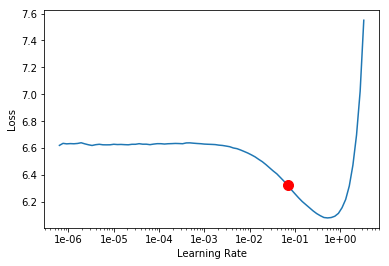

In [16]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion = True)

In [17]:
learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,4.925765,4.107671,0.251311,00:07


In [18]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


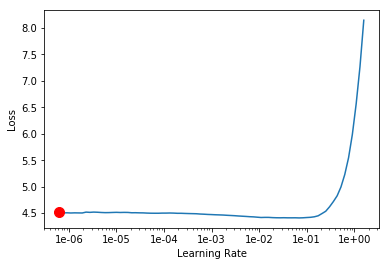

In [19]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion = True)

In [20]:
learn_lm.fit_one_cycle(8, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms = (0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,4.382845,3.983449,0.266239,00:09
1,4.200849,3.835531,0.285268,00:09
2,4.015357,3.750473,0.295201,00:09
3,3.849132,3.699376,0.299414,00:09
4,3.698905,3.668402,0.304297,00:09
5,3.576071,3.654669,0.305831,00:09
6,3.486939,3.650745,0.305776,00:09
7,3.428167,3.650772,0.307087,00:09


As we can see, language model accuracy improved by around 1% after cleaning the tweets; this behaviour persists across various runs on different folds:

In [21]:
from sklearn.model_selection import KFold

split = KFold(n_splits = 10, shuffle = True)

val_losses = []
accuracies = []

for train_idx, valid_idx in split.split(df_clean['text'], df_clean['airline_sentiment'].values):
    df_train = df_clean.iloc[train_idx]
    df_valid = df_clean.iloc[valid_idx]
    
    data_lm = TextLMDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                                   text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)
    
    learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')
    
    learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))  
    
    learn_lm.unfreeze()
    
    learn_lm.fit_one_cycle(15, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms=(0.8,0.7))
    
    val_losses.append(round(learn_lm.recorder.val_losses[-1] ,6))
    accuracies.append(round(learn_lm.recorder.metrics[-1][0].item() ,6))

epoch,train_loss,valid_loss,accuracy,time
0,4.913534,4.115983,0.247545,00:07


epoch,train_loss,valid_loss,accuracy,time


In [22]:
print('Accuracies:', accuracies)
print('Accuracies mean:', np.array(accuracies).mean().round(6))
print('Accuracies standard deviation:', np.array(accuracies).std().round(6))
print()
print('Validation losses:', val_losses)
print('Validation losses mean:', np.array(val_losses).mean().round(6))
print('Validation losses standard deviation:', np.array(val_losses).std().round(6))

Accuracies: [0.311077, 0.313058, 0.314481, 0.311886, 0.312723, 0.313895, 0.318164, 0.314425, 0.313421, 0.306948]
Accuracies mean: 0.313008
Accuracies standard deviation: 0.002711

Validation losses: [3.680325, 3.653186, 3.678188, 3.703152, 3.697039, 3.69647, 3.635584, 3.661692, 3.705574, 3.705214]
Validation losses mean: 3.681642
Validation losses standard deviation: 0.023218


The mean accuracy across runs is around 1.3% higher compared to before, which means the language model finds it a bit easier to predict the next word for cleaned tweets rather than for original ones: this is however most likely due to the fact that we replaced many of the most common words (e.g. tweet references and references to airlines) with "xxunk", so it may not really be a qualitative improvement of the model.

Moving on, let us construct our final language model by training it on as many tweets as possible:

In [23]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits = 1, test_size = 2/14640)

for train_idx, valid_idx in split.split(df_clean['text'], df_clean['airline_sentiment'].values):
    df_train = df_clean.iloc[train_idx]
    df_valid = df_clean.iloc[valid_idx]

In [24]:
data_lm = TextLMDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                                  text_cols = 'text', label_cols = 'airline_sentiment', max_vocab = 60000, min_freq = 2)

In [25]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1.0, model_dir = '/tmp/models')

learn_lm.fit_one_cycle(1, slice(3e-2), wd = 1e-5, moms = (0.8, 0.7))
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, slice(1e-2/(2.6**4), 1e-2), wd = 1e-5, moms = (0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,4.880414,3.472536,0.309598,00:07


epoch,train_loss,valid_loss,accuracy,time
0,4.359672,3.477752,0.332589,00:09
1,4.176515,3.484429,0.277679,00:09
2,3.995898,3.455251,0.319643,00:09
3,3.831699,3.448900,0.325670,00:09
4,3.681311,3.549677,0.343750,00:09
5,3.553458,3.555982,0.296429,00:09
6,3.466201,3.573924,0.336607,00:09
7,3.415214,3.577088,0.340848,00:09


The accuracy seems quite higher now, but this is just due to having a very small number of tweets in the new validation set. The new vocabulary has now 6456 tokens:

In [26]:
len(data_lm.train_ds.vocab.itos)

6456

We shouldn't forget to save the model and its encoder, which will be used later:

In [27]:
learn_lm.save('/kaggle/working/fine_tuned_lm')
learn_lm.save_encoder('/kaggle/working/fine_tuned_enc')

### Training - Classifier Model

At this point we are ready to train a classifier model. The code is exactly as before, the only difference being the new language model. Let us consider five runs on different random (but stratified) choices of training and test sets:

In [28]:
idx_neg = df_clean[df_clean['airline_sentiment'].values == 'negative'].index
idx_neu = df_clean[df_clean['airline_sentiment'].values == 'neutral'].index
idx_pos = df_clean[df_clean['airline_sentiment'].values == 'positive'].index

from sklearn.model_selection import StratifiedShuffleSplit

matrices = []
accuracies = []

for cont in range(5):
    
    split_neg = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
    split_neu = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)
    split_pos = StratifiedShuffleSplit(n_splits = 1, train_size = 2100, test_size = 263)

    for train_idx, valid_idx in split_neg.split(df_clean['negativereason'].loc[idx_neg], df_clean['negativereason'].loc[idx_neg]):
        train_idx_neg = (np.array(idx_neg)[train_idx]).tolist()
        valid_idx_neg = (np.array(idx_neg)[valid_idx]).tolist()
        test_idx_neg = [idx for idx in idx_neg if idx not in train_idx_neg]
    
    for train_idx, valid_idx in split_neu.split(df_clean['airline'].loc[idx_neu], df_clean['airline'].loc[idx_neu]):
        train_idx_neu = (np.array(idx_neu)[train_idx]).tolist()
        valid_idx_neu = (np.array(idx_neu)[valid_idx]).tolist()
        test_idx_neu = [idx for idx in idx_neu if idx not in train_idx_neu]
    
    for train_idx, valid_idx in split_pos.split(df_clean['airline'].loc[idx_pos], df_clean['airline'].loc[idx_pos]):
        train_idx_pos = (np.array(idx_pos)[train_idx]).tolist()
        valid_idx_pos = (np.array(idx_pos)[valid_idx]).tolist()
        test_idx_pos = [idx for idx in idx_pos if idx not in train_idx_pos]
    
    df_train = df_clean.loc[train_idx_neg + train_idx_neu + train_idx_pos].sample(frac = 1)
    df_valid = df_clean.loc[valid_idx_neg + valid_idx_neu + valid_idx_pos].sample(frac = 1)
    df_test = df_clean.loc[test_idx_neg + test_idx_neu + test_idx_pos].sample(frac = 1)
    
    data_clas = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_valid, 
                                   text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)
    
    learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')
    learn_clas.load_encoder('/kaggle/working/fine_tuned_enc')
    
    learn_clas.freeze_to(-1)
    learn_clas.fit_one_cycle(1, 3e-2, wd = 1e-5, moms = (0.8,0.7))
    
    learn_clas.freeze_to(-2)
    learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.freeze_to(-3)
    learn_clas.fit_one_cycle(1, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.unfreeze()
    
    learn_clas.fit_one_cycle(10, slice(1e-4, 1e-3), wd = 1e-5, moms=(0.8,0.7))
    
    learn_clas.save('/kaggle/working/fine_tuned_clas')
    
    data_clas_test = TextClasDataBunch.from_df(path = path, train_df = df_train, valid_df = df_test, 
                                       text_cols = 'text', label_cols = 'airline_sentiment', vocab = data_lm.train_ds.vocab, bs = 256)

    learn_clas_test = text_classifier_learner(data_clas_test, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')

    learn_clas_test.load('/kaggle/working/fine_tuned_clas')

    interp_test = learn_clas_test.interpret()
    
    matrix = interp_test.confusion_matrix()
    
    matrices.append(matrix/(np.sum(matrix, axis = 1).reshape(-1,1)))
        
    accuracies.append(round(np.trace(matrix)/np.sum(matrix), 6))

We can look at the confusion matrix and accuracy score for each run, and compare them against our previous results on non-cleaned tweets:

In [29]:
# Runs on cleaned tweets

for matrix, accuracy in zip(matrices, accuracies):
    print(matrix)
    print()
    print(accuracy)
    print()

[[0.821277 0.115852 0.062871]
 [0.17017  0.693694 0.136136]
 [0.060837 0.102662 0.836502]]

0.806475

[[0.820429 0.126589 0.052981]
 [0.171171 0.707708 0.121121]
 [0.053232 0.110266 0.836502]]

0.807434

[[0.821418 0.120232 0.05835 ]
 [0.139139 0.730731 0.13013 ]
 [0.060837 0.079848 0.859316]]

0.811751

[[0.820429 0.119667 0.059904]
 [0.175175 0.695696 0.129129]
 [0.079848 0.08365  0.836502]]

0.805995

[[0.802204 0.133088 0.064708]
 [0.13013  0.737738 0.132132]
 [0.064639 0.087452 0.847909]]

0.795923



In [77]:
# Previous runs on original tweets

for matrix, accuracy in zip(matrices, accuracies):
    print(matrix)
    print()
    print(accuracy)
    print()

[[0.800085 0.130263 0.069652]
 [0.153153 0.686687 0.16016 ]
 [0.08365  0.053232 0.863118]]

0.788489

[[0.822266 0.116982 0.060752]
 [0.163163 0.696697 0.14014 ]
 [0.079848 0.121673 0.798479]]

0.806475

[[0.791325 0.139587 0.069087]
 [0.125125 0.737738 0.137137]
 [0.068441 0.110266 0.821293]]

0.785851

[[0.82594  0.119101 0.054959]
 [0.162162 0.712713 0.125125]
 [0.041825 0.117871 0.840304]]

0.81283

[[0.805595 0.12885  0.065555]
 [0.156156 0.716717 0.127127]
 [0.045627 0.095057 0.859316]]

0.796643



It is hard to say if our prescription for cleaning tweets had a relevant effect or not: indeed the results for cleaned tweets seem to be a little more stable across runs and to produce a slightly better accuracy, but it is not clear if this is due to our preprocessing step or to the random training/test splitting.

Indeed, also looking at the misclassified examples and at the words which most contributed to misclassification we don't see a big difference from before:

In [30]:
dic = {0:'negative', 1:'neutral', 2:'positive'}

predictions = torch.argmax(learn_clas_test.get_preds(ordered = True)[0], dim = 1)
predictions = [dic[predictions[i].tolist()]  for i in range(len(predictions))]

df_res = df_test.copy()
df_res['predicted_sentiment'] = predictions

text_interp_test = TextClassificationInterpretation.from_learner(learn_clas_test)

# True sentiment neutral, predicted sentiment negative

for i in df_res.loc[(df_res['airline_sentiment'] == 'neutral') & (df_res['predicted_sentiment'] == 'negative')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

("xxunk that's what we've been told however how would this work if you're going overseas? Bottom line is passengers feel as if there's (1)", 'neutral', 'negative')


('xxunk on the plane. I was thoughtful enough to ask for it and got it; there are prob others that also deserved it', 'neutral', 'negative')


("xxunk Thanks for reminding me about my upcoming trip to Florida but you really didn't need to... ", 'neutral', 'negative')


('xxunk I just had an interview how long does it take before you hear back', 'neutral', 'negative')


("xxunk Does your home airport not count in the badge system? My TB account says 2 flights but I've taken 3 this year.", 'neutral', 'negative')


('xxunk and xxunk have Cancelled Flightled flights after 525 pm today due to winter storm. Travelers urged to contact carrier for info.', 'neutral', 'negative')


("xxunk [checked in + boardingpass w/no checkin bagage] guess i'm all set. :-)", 'neutral', 'negative')


("xxunk UA flight 1247. SFO to LAX took my carry on at gate. I'm Group 2, overhead bins are empty", 'neutral', 'negative')


('xxunk there is a sector whereby it says $0 in both bags...no bag allowance at all in international flight?', 'neutral', 'negative')


('xxunk nope.  no case id either time.', 'neutral', 'negative')


In [31]:
# True sentiment negative, predicted sentiment neutral 

for i in df_res.loc[(df_res['airline_sentiment'] == 'negative') & (df_res['predicted_sentiment'] == 'neutral')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('xxunk yes I have', 'negative', 'neutral')


('xxunk 37 minutes??????', 'negative', 'neutral')


('xxunk Customer service said it was a known problem that they were using same confirmation numbers for domestic and international', 'negative', 'neutral')


('xxunk Now submitted for the third time, please check and confirm receipt. Have taken screen shots in case it disappears again. Thanks', 'negative', 'neutral')


("xxunk Thanks, but that results in missing the conference I'm attending. Are there options to book earlier,or if not,receive a refund?", 'negative', 'neutral')


('xxunk I have two tight connections in Charlotte and Frankfurt', 'negative', 'neutral')


("xxunk or I'm sure her business will go else where for airline travel. Her name is Kathryn Sotelo", 'negative', 'neutral')


("xxunk my flt is at 7a tom. I have now rec'd notification that I'm going out from some other airport", 'negative', 'neutral')


('xxunk can you tell me how to file a claim for clothing that had to be purchased?', 'negative', 'neutral')


("I hate you all. RT xxunk: Our fleet's on fleek. ", 'negative', 'neutral')


In [32]:
# True sentiment neutral, predicted sentiment positive 

for i in df_res.loc[(df_res['airline_sentiment'] == 'neutral') & (df_res['predicted_sentiment'] == 'positive')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

("xxunk Hey! Check it out!! It's snowing in Boston. Who could have predicted such a thing?! ", 'neutral', 'positive')


('xxunk I know where you guys jet! LOL, but if you love me so much, help a brother out :) Hot weather, great nightlife, 2-3 hour flight', 'neutral', 'positive')


('xxunk here we go again, 2nd round trip to CA in a week True Blue', 'neutral', 'positive')


("xxunk just kidding with you I'll send you my stuff now. Thanks", 'neutral', 'positive')


("xxunk thanks! I only loose 'em at airports...1st time we found it. I think xxunk needs to make flexes that stay on when carrying bags!", 'neutral', 'positive')


('xxunk xxunk please help me and my best friend get tickets to Destination Dragons we have so much to thank them for....', 'neutral', 'positive')


("xxunk I'm aware, I fly a lot :) Just sad I had to change my shoes (boots), ha! Happy Flight", 'neutral', 'positive')


('xxunk Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃', 'neutral', 'positive')


('xxunk yes, with Delta!', 'neutral', 'positive')


('xxunk sounds fun! How does that work?', 'neutral', 'positive')


In [33]:
# True sentiment positive, predicted sentiment neutral 

for i in df_res.loc[(df_res['airline_sentiment'] == 'positive') & (df_res['predicted_sentiment'] == 'neutral')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

('xxunk when are you releasing your flights for September? Just found out you fly direct lbb to las! So excited! tripofalifetime', 'positive', 'neutral')


('xxunk me and xxunk are best friends because of xxunk. Any chance we could get tickets to Destination Dragons ?', 'positive', 'neutral')


('xxunk will do. Just need to get CVG.... and my bag too. Thanks', 'positive', 'neutral')


("xxunk I'm flying with your competitor today, starts with an U and ends with D. I will never make that mistake again. americanforlife", 'positive', 'neutral')


('xxunk I might look into that. My wife travels much more than I do. Could we both use the membership?', 'positive', 'neutral')


('xxunk If you "follow" me, I will be able to DM you.  Thanks.', 'positive', 'neutral')


("Power Moves RT xxunk: Our fleet's on fleek. ", 'positive', 'neutral')


('xxunk you know it. Need it on my spotify stat guiltypleasures', 'positive', 'neutral')


('xxunk I will do just about anything tO GO TO THE VEGAS SHOW PLEASE MAN', 'positive', 'neutral')


('xxunk rules.', 'positive', 'neutral')


In [34]:
# True sentiment positive, predicted sentiment negative 

for i in df_res.loc[(df_res['airline_sentiment'] == 'positive') & (df_res['predicted_sentiment'] == 'negative')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

("xxunk thanks Travis at PHL A East checkin for knowing baggage policies. Skis and boots count as 1. Teach your mgr who didn't know", 'positive', 'negative')


('xxunk this is why I fly xxunk ... Never have any issues', 'positive', 'negative')


('xxunk Leave BUR ten minutes Late Flight and arrive in SJC a minute before we were supposed to... Impressed! gettingbetter 👍', 'positive', 'negative')


('xxunk thanks for getting us to NYC -JFK really safely. :-) But srsly? How long does it take to get our checked bags? eternity 5amMisery', 'positive', 'negative')


("xxunk  glad to be home and that your great people got me home safely. Sad for others who didn't get back bc of scheduling problems.", 'positive', 'negative')


("xxunk Well plane arrived pretty much on time and it's 68 degrees on the ground in Texas. Not much to complain about.", 'positive', 'negative')


('xxunk xxunk : outsource it all United Airlines...your customers  are just loving you for it. Outsource. Outsource. Outsource.', 'positive', 'negative')


("xxunk xxunk xxunk You take to me places xxunk simply can't...like non-stop to St. Lucia.", 'positive', 'negative')


('xxunk one lady helping the 12 of us with luggage', 'positive', 'negative')


('xxunk provide a voucher for one of my customers and I will tweet about you all day long earnedmybusiness', 'positive', 'negative')


In [35]:
# True sentiment negative, predicted sentiment positive 

for i in df_res.loc[(df_res['airline_sentiment'] == 'negative') & (df_res['predicted_sentiment'] == 'positive')].index[0:10]:
    print((df_res['text'].loc[i], df_res['airline_sentiment'].loc[i], df_res['predicted_sentiment'].loc[i]))
    text_interp_test.show_intrinsic_attention(df_res['text'].loc[i], cmap = mpl.cm.Purples)

("xxunk but in the meantime I'll be sleeping on a park bench on dadeland st.  Thanks guys!", 'negative', 'positive')


("xxunk that's quite an impressive list of fees!", 'negative', 'positive')


('xxunk because of you, I am doing the one thing I tried to avoid. Thank you for sending me to baggage claim.', 'negative', 'positive')


('xxunk we are waiting flight 919 !\nWe are at JFK for about 24h !! New York 919 viracopos American Airlines ', 'negative', 'positive')


('xxunk: I feel very well informed. yes, the flight is indeed delayed. Thank you. ', 'negative', 'positive')


('xxunk thanks! I expected a wait... Just not that long. :)', 'negative', 'positive')


('xxunk the wifi in the ewr lounge reminds me of the old days of dial up', 'negative', 'positive')


('xxunk i think he actually did not like your screen  xxunk 😃😃😃', 'negative', 'positive')


("xxunk Thank you for the acknowledgement. The IFE didn't work all that well anyway so maybe time to upgrade to lower profile system.", 'negative', 'positive')


("xxunk amazing to me that we can't get any cold air from the vents. VX 358 noair worstflightever roasted SF Oto BOS", 'negative', 'positive')


***

# Conclusions

In this exercise we used the fastai library to train a ULMFiT model to classify the sentiment (negative, neutral or positive) of tweets in the Twitter US Airlines Sentiment dataset. 

The dataset is quite imbalanced, with many more negative tweets than neutral or positive: for this reason the ~ 80% accuracy we obtained is not really meaningful, but we should look at the confusion matrix instead. The confusion matrix tells us that the ULMFiT classifier is able to correctly identify negative and positive tweets around 80% of the times or more, while neutral tweets are only correctly identified around 70% of the times: this is as expected, both because of the presence of possibly misclassified tweets and for the fact that even for humans distinguishing neutral and negative/positive sentiment may be quite subtle.

Cleaning tweets by removing websites, tweets references and splitting words in hashtags did not seem to improve the classifier model significantly, although it had a noticeable effect on the language model; it may however be possible to improve the classifier further by choosing different and more elaborate preprocessing and cleaning steps.

We should also mention that in this exercise we were required to train an ULMFiT model, but this may not be the best model for the problem at hand: it would therefore be worth studying the performance of other models on the same dataset.